In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
import os
from matplotlib.image import imread

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, \
    BatchNormalization, Conv2D,Conv2DTranspose, Activation, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
image_path = 'F:\\images\\coffee cup icon'

In [6]:
# widths = []
# heights = []
# for image_filename in os.listdir(image_path + '\\sub'):
    
#     img = imread(image_path + '\\sub' + '\\' + image_filename)
#     width, height, _ = img.shape
#     widths.append(width)
#     heights.append(height)

In [7]:
# sns.jointplot(widths, heights)

In [8]:
# np.median(widths)

In [9]:
# np.median(heights)

In [10]:
image_shapes = (224, 224, 3)
batch_size = 16
dim = 28
depth = 128
input_dim = 100

In [11]:
image_gen = ImageDataGenerator()

In [12]:
image_generator = image_gen.flow_from_directory(
    directory=image_path,
    target_size=image_shapes[:2],
    color_mode='rgb',
    batch_size=batch_size,
    save_format='jpg',
    class_mode=None
)

Found 1028 images belonging to 1 classes.


In [13]:
class DCGAN:
    def __init__(self, image_shapes, batch_size, dim, depth, input_dim, dropout=0.0):
        self.image_shapes = image_shapes
        self.batch_size = batch_size
        self.dim = dim
        self.depth = depth
        self.input_dim = input_dim
        self.dropout = dropout
        
    def generator(self):
        generator = Sequential()

        generator.add(Dense(self.dim * self.dim * self.depth, input_shape=[self.input_dim]))
        generator.add(Reshape((self.dim, self.dim, self.depth)))
        generator.add(BatchNormalization())
        generator.add(Activation('relu'))

        generator.add(Conv2DTranspose(int(self.depth/2), kernel_size=(5, 5), strides=2, padding='same'))
        generator.add(BatchNormalization())
        generator.add(Activation('relu'))

        generator.add(Conv2DTranspose(int(self.depth/4), kernel_size=(5, 5), strides=2, padding='same'))
        generator.add(BatchNormalization())
        generator.add(Activation('relu'))

        generator.add(Conv2DTranspose(3, kernel_size=(5, 5), strides=2, padding='same'))
        generator.add(Activation('tanh'))
        
        return generator
    
    def discriminator(self):
        discriminator = Sequential()
        
        discriminator.add(Conv2D(int(depth/4), kernel_size=(5, 5), strides=2, padding="same",
                                 input_shape=self.image_shapes))
        discriminator.add(LeakyReLU())
        discriminator.add(Dropout(self.dropout))
        
        discriminator.add(Conv2D(depth/2, kernel_size=(5, 5), strides=2, padding="same"))
        discriminator.add(LeakyReLU())
        discriminator.add(Dropout(self.dropout))
        
        discriminator.add(Conv2D(depth, kernel_size=(5, 5), strides=2, padding="same"))
        discriminator.add(LeakyReLU())
        discriminator.add(Dropout(self.dropout))
        
        discriminator.add(Flatten())
        discriminator.add(Dense(1))
        discriminator.add(Activation('sigmoid'))
        
        return discriminator

In [14]:
DCGAN = DCGAN(image_shapes, batch_size, dim, depth, input_dim, dropout=0.2)
generator = DCGAN.generator()
discriminator = DCGAN.discriminator()

In [15]:
# generator.summary()
# discriminator.summary()

In [16]:
optimizer = Adam(learning_rate=0.0002)

In [17]:
# generator.compile(loss='binary_crossentropy',
#                       optimizer=optimizer)

In [18]:
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer)
discriminator.trainable = False

In [19]:
GAN = Sequential([generator, discriminator])

In [20]:
GAN.compile(loss="binary_crossentropy", optimizer=optimizer)

In [21]:
GAN.layers

In [22]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       10394947  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 358977    
Total params: 10,753,924
Trainable params: 10,394,499
Non-trainable params: 359,425
_________________________________________________________________


In [23]:
def train_dcgan(epochs):
    
    generator, discriminator = GAN.layers
    number_of_batches = len(image_generator)

    # Variables that will be used to plot the losses from the discriminator and
    # the adversarial models
    adversarial_loss = np.empty(shape=1)
    discriminator_loss = np.empty(shape=1)
    batches = np.empty(shape=1)

    # Allo plot updates inside for loop
    plt.ion()

    current_batch = 0

    # Let's train the DCGAN for n epochs
    for epoch in range(1, epochs+1):

        print("Epoch " + str(epoch) + "/" + str(epochs) + " :")

        for batch_number in range(number_of_batches):

            start_time = time.time()

            # Get the current batch and normalize the images between -1 and 1
            real_images = image_generator.next()
            real_images /= 127.5
            real_images -= 1

            # The last batch is smaller than the other ones, so we need to
            # take that into account
            current_batch_size = real_images.shape[0]

            # Generate noise
            noise = tf.random.normal(shape=[current_batch_size, input_dim])

            # Generate images
            generated_images = generator.predict(noise)
            
            X_fake_vs_real = tf.concat([generated_images, tf.dtypes.cast(real_images,tf.float32)], axis=0)
            
            y = tf.constant([[0.]] * current_batch_size + [[1.]] * current_batch_size)

            # Let's train the discriminator
            discriminator.trainable = True

            d_loss = discriminator.train_on_batch(X_fake_vs_real, y)

            discriminator_loss = np.append(discriminator_loss, d_loss)

            # Now it's time to train the generator
            discriminator.trainable = False

            noise = tf.random.normal(shape=[current_batch_size * 2, input_dim])

            # We try to mislead the discriminator by giving the opposite labels
            fake_y = np.ones(current_batch_size * 2)

            g_loss = GAN.train_on_batch(noise, fake_y)
            adversarial_loss = np.append(adversarial_loss ,g_loss)
            batches = np.append(batches, current_batch)

            # Each 50 batches show and save images
#             if (batch_number + 1) % 10 == 0:
#                 save_generated_images(generated_images, epoch, batch_number)

            time_elapsed = time.time() - start_time

            # Display and plot the results
            print("     Batch " + str(batch_number + 1) + "/" +
                  str(number_of_batches) +
                  " generator loss | discriminator loss : " +
                  str(g_loss) + " | " + str(d_loss) + ' - batch took ' +
                  str(time_elapsed) + ' s.')

            current_batch += 1

        # Save the model weights each 5 epochs
        if epoch % 20 == 0:
            discriminator.trainable = True
            generator.save('models/generator_epoch_' + str(epoch) + '_' + str(adversarial_loss[-1]) + '.h5')
            discriminator.save('models/discriminator_epoch_' +
                               str(epoch)+ '_' + str(discriminator_loss[-1]) + '.h5')

        # Each epoch update the loss graphs
        plt.figure(1)
        plt.plot(batches, adversarial_loss, color='green',
                 label='Generator Loss')
        plt.plot(batches, discriminator_loss, color='blue',
                 label='Discriminator Loss')
        plt.title("DCGAN Train")
        plt.xlabel("Batch Iteration")
        plt.ylabel("Loss")
        if epoch == 0:
            plt.legend()
        plt.pause(0.0000000001)
        plt.show()

Epoch 1/100 :
     Batch 1/65 generator loss | discriminator loss : 0.5580875873565674 | 0.7045494914054871 - batch took 6.435897350311279 s.
     Batch 2/65 generator loss | discriminator loss : 0.3916128873825073 | 0.4650055170059204 - batch took 4.434263706207275 s.
     Batch 3/65 generator loss | discriminator loss : 0.22361408174037933 | 0.3928488790988922 - batch took 4.282355070114136 s.
     Batch 4/65 generator loss | discriminator loss : 0.11153210699558258 | 0.3614916205406189 - batch took 4.343319654464722 s.
     Batch 5/65 generator loss | discriminator loss : 0.04674899950623512 | 0.3551090359687805 - batch took 4.486231088638306 s.
     Batch 6/65 generator loss | discriminator loss : 0.018713491037487984 | 0.3535541296005249 - batch took 4.3443169593811035 s.
     Batch 7/65 generator loss | discriminator loss : 0.007896104827523232 | 0.34887468814849854 - batch took 4.341320037841797 s.
     Batch 8/65 generator loss | discriminator loss : 0.003463271539658308 | 0.34

     Batch 63/65 generator loss | discriminator loss : 0.0002249305252917111 | 8.23292248242069e-06 - batch took 4.308339357376099 s.
     Batch 64/65 generator loss | discriminator loss : 0.0010765529004856944 | 6.43070598016493e-06 - batch took 4.255374431610107 s.
     Batch 65/65 generator loss | discriminator loss : 0.0034098289906978607 | 4.827878910873551e-06 - batch took 2.1596667766571045 s.


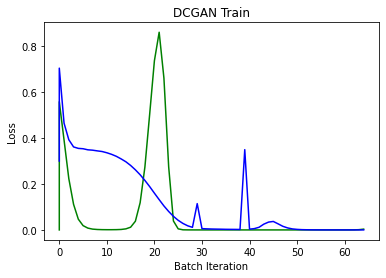

Epoch 2/100 :
     Batch 1/65 generator loss | discriminator loss : 0.00633070757612586 | 4.307305971451569e-06 - batch took 4.27786660194397 s.
     Batch 2/65 generator loss | discriminator loss : 0.0018472594674676657 | 4.27311533712782e-06 - batch took 4.306342124938965 s.
     Batch 3/65 generator loss | discriminator loss : 0.00042411251342855394 | 4.587512194120791e-06 - batch took 4.310337781906128 s.
     Batch 4/65 generator loss | discriminator loss : 0.00010106886475114152 | 5.297072675602976e-06 - batch took 4.473238706588745 s.
     Batch 5/65 generator loss | discriminator loss : 2.438105730107054e-05 | 5.565851097344421e-06 - batch took 4.345318078994751 s.
     Batch 6/65 generator loss | discriminator loss : 6.475107511505485e-06 | 6.654239768977277e-06 - batch took 4.281357288360596 s.
     Batch 7/65 generator loss | discriminator loss : 1.814786514842126e-06 | 6.865379873488564e-06 - batch took 4.3313257694244385 s.
     Batch 8/65 generator loss | discriminator lo

     Batch 62/65 generator loss | discriminator loss : 3.268590080551803e-05 | 3.155574813717976e-05 - batch took 4.297347545623779 s.
     Batch 63/65 generator loss | discriminator loss : 4.6240384108386934e-05 | 2.8552734875120223e-05 - batch took 4.308340549468994 s.
     Batch 64/65 generator loss | discriminator loss : 7.572049798909575e-05 | 2.8553698939504102e-05 - batch took 4.406278610229492 s.
     Batch 65/65 generator loss | discriminator loss : 8.051907934714109e-05 | 3.1750834750710055e-05 - batch took 1.169278621673584 s.


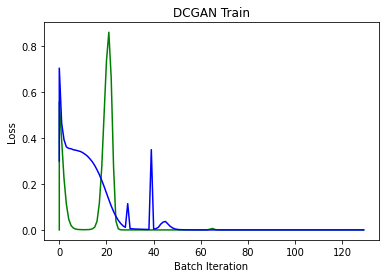

Epoch 3/100 :
     Batch 1/65 generator loss | discriminator loss : 8.063563291216269e-05 | 2.751491774688475e-05 - batch took 4.396283864974976 s.
     Batch 2/65 generator loss | discriminator loss : 0.00011234160047024488 | 2.76758692052681e-05 - batch took 4.314336776733398 s.
     Batch 3/65 generator loss | discriminator loss : 0.00011845036351587623 | 2.8401747840689495e-05 - batch took 4.291350603103638 s.
     Batch 4/65 generator loss | discriminator loss : 0.00015627252287231386 | 2.8633236070163548e-05 - batch took 4.309340476989746 s.
     Batch 5/65 generator loss | discriminator loss : 0.00015191994316410273 | 2.809070429066196e-05 - batch took 4.380295515060425 s.
     Batch 6/65 generator loss | discriminator loss : 0.00015103713667485863 | 3.0405863071791828e-05 - batch took 4.2853546142578125 s.
     Batch 7/65 generator loss | discriminator loss : 0.00014349566481541842 | 2.955532181658782e-05 - batch took 4.3223326206207275 s.
     Batch 8/65 generator loss | discr

     Batch 62/65 generator loss | discriminator loss : 6.975623546168208e-05 | 3.193078737240285e-05 - batch took 4.320332050323486 s.
     Batch 63/65 generator loss | discriminator loss : 7.731329969828948e-05 | 3.290372114861384e-05 - batch took 4.241381645202637 s.
     Batch 64/65 generator loss | discriminator loss : 9.401748684467748e-05 | 3.1921721529215574e-05 - batch took 4.319334030151367 s.
     Batch 65/65 generator loss | discriminator loss : 6.293672777246684e-05 | 3.459849540377036e-05 - batch took 1.1882667541503906 s.


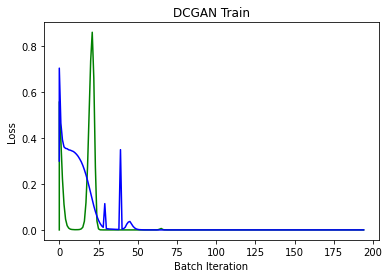

Epoch 4/100 :
     Batch 1/65 generator loss | discriminator loss : 6.87368301441893e-05 | 3.3462129067629576e-05 - batch took 4.223391771316528 s.
     Batch 2/65 generator loss | discriminator loss : 8.429714216617867e-05 | 3.144657603115775e-05 - batch took 4.366304397583008 s.
     Batch 3/65 generator loss | discriminator loss : 5.766913091065362e-05 | 3.152259887428954e-05 - batch took 4.335323095321655 s.
     Batch 4/65 generator loss | discriminator loss : 6.883119931444526e-05 | 3.096937871305272e-05 - batch took 4.285354137420654 s.
     Batch 5/65 generator loss | discriminator loss : 0.00010625545110087842 | 2.8810205549234524e-05 - batch took 4.2733612060546875 s.
     Batch 6/65 generator loss | discriminator loss : 6.352634954964742e-05 | 3.325464786030352e-05 - batch took 4.43526291847229 s.
     Batch 7/65 generator loss | discriminator loss : 6.30680879112333e-05 | 3.4777804103214294e-05 - batch took 4.336322546005249 s.
     Batch 8/65 generator loss | discriminator

     Batch 62/65 generator loss | discriminator loss : 9.551475523039699e-05 | 3.0793995392741635e-05 - batch took 4.418272018432617 s.
     Batch 63/65 generator loss | discriminator loss : 7.74862855905667e-05 | 2.0641662558773533e-05 - batch took 4.329328775405884 s.
     Batch 64/65 generator loss | discriminator loss : 6.478128489106894e-05 | 3.019149153260514e-05 - batch took 4.275361776351929 s.
     Batch 65/65 generator loss | discriminator loss : 5.331287320586853e-05 | 2.056015728157945e-05 - batch took 1.2302393913269043 s.


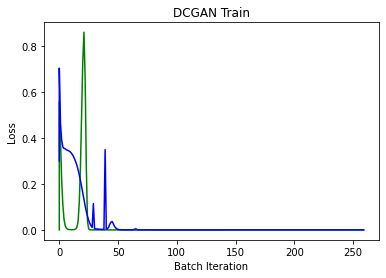

Epoch 5/100 :
     Batch 1/65 generator loss | discriminator loss : 5.2453007810981944e-05 | 2.9327675292734057e-05 - batch took 4.249379396438599 s.
     Batch 2/65 generator loss | discriminator loss : 8.438773511443287e-05 | 3.136636223644018e-05 - batch took 4.344317674636841 s.
     Batch 3/65 generator loss | discriminator loss : 4.8438952944707125e-05 | 1.946020347531885e-05 - batch took 4.442256212234497 s.
     Batch 4/65 generator loss | discriminator loss : 0.00010408264643047005 | 2.1574418497039005e-05 - batch took 4.298348426818848 s.
     Batch 5/65 generator loss | discriminator loss : 9.303100523538888e-05 | 2.0195515389787033e-05 - batch took 4.240381956100464 s.
     Batch 6/65 generator loss | discriminator loss : 7.469291449524462e-05 | 1.5220678506011609e-05 - batch took 4.328329086303711 s.
     Batch 7/65 generator loss | discriminator loss : 7.198181265266612e-05 | 1.8161848856834695e-05 - batch took 4.400283098220825 s.
     Batch 8/65 generator loss | discrim

     Batch 62/65 generator loss | discriminator loss : 0.00016171584138646722 | 2.5510162231512368e-05 - batch took 4.292349576950073 s.
     Batch 63/65 generator loss | discriminator loss : 4.988811269868165e-05 | 2.0004781617899425e-05 - batch took 4.379296541213989 s.
     Batch 64/65 generator loss | discriminator loss : 7.574164919788018e-05 | 2.3396061806124635e-05 - batch took 4.3932881355285645 s.
     Batch 65/65 generator loss | discriminator loss : 6.178869807627052e-05 | 4.4479631469585e-05 - batch took 1.1772737503051758 s.


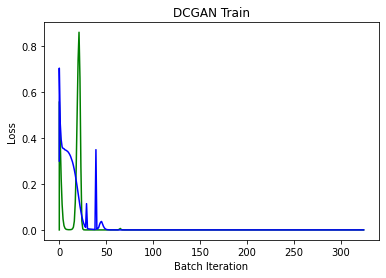

Epoch 6/100 :
     Batch 1/65 generator loss | discriminator loss : 0.0004509874852374196 | 2.8190166631247848e-05 - batch took 4.290348052978516 s.
     Batch 2/65 generator loss | discriminator loss : 4.5576118282042444e-05 | 1.790697206160985e-05 - batch took 4.302345514297485 s.
     Batch 3/65 generator loss | discriminator loss : 3.837026815745048e-05 | 2.677971133380197e-05 - batch took 4.3253302574157715 s.
     Batch 4/65 generator loss | discriminator loss : 2.7373627744964324e-05 | 1.7412074157618918e-05 - batch took 4.400284051895142 s.
     Batch 5/65 generator loss | discriminator loss : 2.5983696104958653e-05 | 4.910440475214273e-05 - batch took 4.300344705581665 s.
     Batch 6/65 generator loss | discriminator loss : 3.7058805901324376e-05 | 7.008129614405334e-05 - batch took 4.2953479290008545 s.
     Batch 7/65 generator loss | discriminator loss : 6.595112790819257e-05 | 3.722857218235731e-05 - batch took 4.28435492515564 s.
     Batch 8/65 generator loss | discrimi

     Batch 62/65 generator loss | discriminator loss : 0.0008202795870602131 | 0.0001958755310624838 - batch took 4.299346685409546 s.
     Batch 63/65 generator loss | discriminator loss : 0.0015690340660512447 | 0.00019411748507991433 - batch took 4.323331117630005 s.
     Batch 64/65 generator loss | discriminator loss : 0.003905307734385133 | 0.00021988843218423426 - batch took 4.4002845287323 s.
     Batch 65/65 generator loss | discriminator loss : 0.0019973344169557095 | 0.0006485365447588265 - batch took 1.1832704544067383 s.


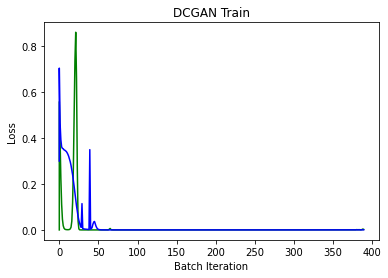

Epoch 7/100 :
     Batch 1/65 generator loss | discriminator loss : 0.12773820757865906 | 0.0012274241307750344 - batch took 4.396280765533447 s.
     Batch 2/65 generator loss | discriminator loss : 26.065841674804688 | 0.8367891907691956 - batch took 4.279357671737671 s.
     Batch 3/65 generator loss | discriminator loss : 33.57060241699219 | 3.7199015423539095e-06 - batch took 4.265367746353149 s.
     Batch 4/65 generator loss | discriminator loss : 26.987918853759766 | 1.813808012229856e-06 - batch took 4.314336061477661 s.
     Batch 5/65 generator loss | discriminator loss : 13.887904167175293 | 0.0014636883279308677 - batch took 4.375298500061035 s.
     Batch 6/65 generator loss | discriminator loss : 18.459836959838867 | 1.3026717901229858 - batch took 4.301344394683838 s.
     Batch 7/65 generator loss | discriminator loss : 6.556765556335449 | 8.862006187438965 - batch took 4.358310699462891 s.
     Batch 8/65 generator loss | discriminator loss : 7.23223352432251 | 3.7052

     Batch 65/65 generator loss | discriminator loss : 2.0857925415039062 | 0.00015296328638214618 - batch took 1.188267469406128 s.


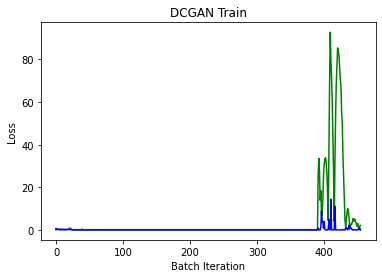

Epoch 8/100 :
     Batch 1/65 generator loss | discriminator loss : 9.882293701171875 | 2.8129774364060722e-05 - batch took 4.248378038406372 s.
     Batch 2/65 generator loss | discriminator loss : 12.639291763305664 | 0.0006019041175022721 - batch took 4.397285461425781 s.
     Batch 3/65 generator loss | discriminator loss : 13.456575393676758 | 1.667433261871338 - batch took 4.337321996688843 s.
     Batch 4/65 generator loss | discriminator loss : 15.50511360168457 | 1.0697943864101944e-08 - batch took 4.330326557159424 s.
     Batch 5/65 generator loss | discriminator loss : 13.014028549194336 | 4.3991355697103884e-11 - batch took 4.274361610412598 s.
     Batch 6/65 generator loss | discriminator loss : 13.097542762756348 | 2.2642178409970626e-10 - batch took 4.420271158218384 s.
     Batch 7/65 generator loss | discriminator loss : 13.23701286315918 | 1.0742061462565289e-08 - batch took 4.314338207244873 s.
     Batch 8/65 generator loss | discriminator loss : 13.86956310272216

     Batch 64/65 generator loss | discriminator loss : 3.44759464263916 | 0.0031873038969933987 - batch took 4.302342891693115 s.
     Batch 65/65 generator loss | discriminator loss : 2.448033332824707 | 0.7683849930763245 - batch took 1.2242436408996582 s.


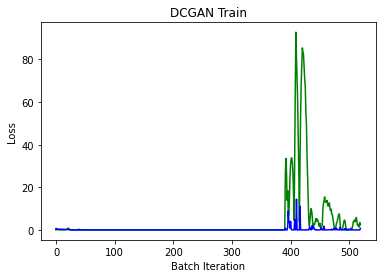

Epoch 9/100 :
     Batch 1/65 generator loss | discriminator loss : 2.7752089500427246 | 0.05204647779464722 - batch took 4.229753494262695 s.
     Batch 2/65 generator loss | discriminator loss : 4.344437122344971 | 0.0006165346130728722 - batch took 4.310338973999023 s.
     Batch 3/65 generator loss | discriminator loss : 8.523574829101562 | 0.00044341018656268716 - batch took 4.408278703689575 s.
     Batch 4/65 generator loss | discriminator loss : 9.7611083984375 | 4.9244197725784034e-05 - batch took 4.308339834213257 s.
     Batch 5/65 generator loss | discriminator loss : 10.764021873474121 | 4.700868885265663e-05 - batch took 4.260370492935181 s.
     Batch 6/65 generator loss | discriminator loss : 11.439390182495117 | 3.603141158237122e-05 - batch took 4.330326557159424 s.
     Batch 7/65 generator loss | discriminator loss : 11.110637664794922 | 3.1525349186267704e-05 - batch took 4.461245536804199 s.
     Batch 8/65 generator loss | discriminator loss : 8.542844772338867 |

     Batch 63/65 generator loss | discriminator loss : 0.0008821880910545588 | 3.705370909301564e-05 - batch took 4.436262845993042 s.
     Batch 64/65 generator loss | discriminator loss : 0.00017781954375095665 | 0.0005929186590947211 - batch took 4.310338258743286 s.
     Batch 65/65 generator loss | discriminator loss : 0.00016952914302237332 | 0.0002190624363720417 - batch took 1.1762731075286865 s.


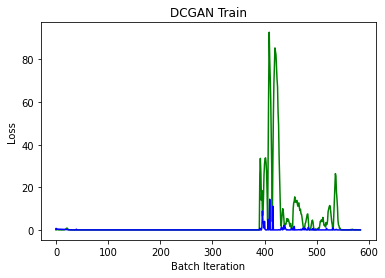

Epoch 10/100 :
     Batch 1/65 generator loss | discriminator loss : 0.000550093362107873 | 0.00026360421907156706 - batch took 4.338324308395386 s.
     Batch 2/65 generator loss | discriminator loss : 0.0009605524828657508 | 3.120208566542715e-05 - batch took 4.276360273361206 s.
     Batch 3/65 generator loss | discriminator loss : 7.170102617237717e-05 | 0.00017591373762115836 - batch took 4.323331356048584 s.
     Batch 4/65 generator loss | discriminator loss : 0.0003671643789857626 | 0.00038210832281038165 - batch took 4.421270847320557 s.
     Batch 5/65 generator loss | discriminator loss : 4.8355330363847315e-05 | 0.00048646016512066126 - batch took 4.320332288742065 s.
     Batch 6/65 generator loss | discriminator loss : 0.0001893303997348994 | 9.826554742176086e-05 - batch took 4.376298666000366 s.
     Batch 7/65 generator loss | discriminator loss : 0.01111094281077385 | 0.00022008478117641062 - batch took 4.50921630859375 s.
     Batch 8/65 generator loss | discriminato

     Batch 63/65 generator loss | discriminator loss : 0.08054570853710175 | 0.0008126262109726667 - batch took 4.3043434619903564 s.
     Batch 64/65 generator loss | discriminator loss : 0.27195823192596436 | 0.0020398644264787436 - batch took 4.416274547576904 s.
     Batch 65/65 generator loss | discriminator loss : 0.1373259574174881 | 0.0005239508464001119 - batch took 1.1612842082977295 s.


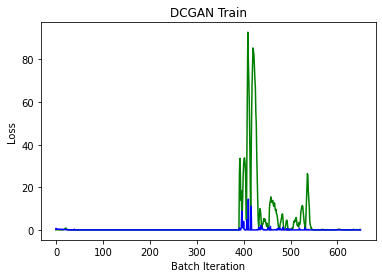

Epoch 11/100 :
     Batch 1/65 generator loss | discriminator loss : 0.19706735014915466 | 0.00098102493211627 - batch took 4.395202875137329 s.
     Batch 2/65 generator loss | discriminator loss : 0.07760488241910934 | 0.002015998587012291 - batch took 4.280358791351318 s.
     Batch 3/65 generator loss | discriminator loss : 0.05247880890965462 | 0.0015750509919598699 - batch took 4.243380308151245 s.
     Batch 4/65 generator loss | discriminator loss : 0.10539577901363373 | 0.0009157671593129635 - batch took 4.2963478565216064 s.
     Batch 5/65 generator loss | discriminator loss : 0.05136100947856903 | 0.002511331345885992 - batch took 4.411276340484619 s.
     Batch 6/65 generator loss | discriminator loss : 0.027536094188690186 | 0.0020945044234395027 - batch took 4.327329158782959 s.
     Batch 7/65 generator loss | discriminator loss : 0.04076148569583893 | 0.014767607674002647 - batch took 4.303342819213867 s.
     Batch 8/65 generator loss | discriminator loss : 0.21248057

     Batch 63/65 generator loss | discriminator loss : 0.20629507303237915 | 0.01092882826924324 - batch took 4.251375198364258 s.
     Batch 64/65 generator loss | discriminator loss : 0.5501284599304199 | 0.05611661821603775 - batch took 4.292349576950073 s.
     Batch 65/65 generator loss | discriminator loss : 0.4310859441757202 | 0.0037833943497389555 - batch took 1.199260950088501 s.


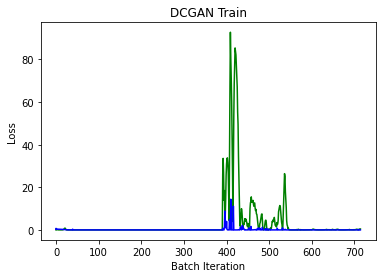

Epoch 12/100 :
     Batch 1/65 generator loss | discriminator loss : 0.39515215158462524 | 0.0011035327333956957 - batch took 4.214398145675659 s.
     Batch 2/65 generator loss | discriminator loss : 0.8731409907341003 | 0.0006008797790855169 - batch took 4.38729190826416 s.
     Batch 3/65 generator loss | discriminator loss : 0.663185179233551 | 0.0005312355351634324 - batch took 4.338322162628174 s.
     Batch 4/65 generator loss | discriminator loss : 0.8615949153900146 | 0.00045697501627728343 - batch took 4.29934549331665 s.
     Batch 5/65 generator loss | discriminator loss : 0.7846564054489136 | 0.00043119449401274323 - batch took 4.276360511779785 s.
     Batch 6/65 generator loss | discriminator loss : 0.8414179086685181 | 0.0011283638887107372 - batch took 4.421270370483398 s.
     Batch 7/65 generator loss | discriminator loss : 0.4834553599357605 | 0.0015729350270703435 - batch took 4.339320421218872 s.
     Batch 8/65 generator loss | discriminator loss : 0.287136495113

     Batch 64/65 generator loss | discriminator loss : 8.359134674072266 | 0.0036947494372725487 - batch took 4.330327272415161 s.
     Batch 65/65 generator loss | discriminator loss : 7.062306880950928 | 0.010253015905618668 - batch took 1.2152502536773682 s.


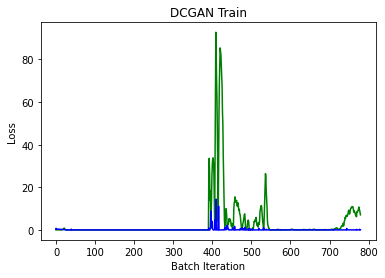

Epoch 13/100 :
     Batch 1/65 generator loss | discriminator loss : 8.51439094543457 | 0.11799406260251999 - batch took 4.265361547470093 s.
     Batch 2/65 generator loss | discriminator loss : 8.492416381835938 | 0.013713674619793892 - batch took 4.307341575622559 s.
     Batch 3/65 generator loss | discriminator loss : 7.974391460418701 | 0.032489508390426636 - batch took 4.408278465270996 s.
     Batch 4/65 generator loss | discriminator loss : 7.719192028045654 | 0.014918839558959007 - batch took 4.3633058071136475 s.
     Batch 5/65 generator loss | discriminator loss : 5.675034523010254 | 0.00967392511665821 - batch took 4.2743613719940186 s.
     Batch 6/65 generator loss | discriminator loss : 6.399809837341309 | 0.19698429107666016 - batch took 4.318334579467773 s.
     Batch 7/65 generator loss | discriminator loss : 7.440332412719727 | 0.015239343978464603 - batch took 4.40827751159668 s.
     Batch 8/65 generator loss | discriminator loss : 7.383529186248779 | 0.000999872

     Batch 63/65 generator loss | discriminator loss : 0.03310823440551758 | 0.009406594559550285 - batch took 4.427266597747803 s.
     Batch 64/65 generator loss | discriminator loss : 0.01000868808478117 | 2.944895716172624e-11 - batch took 4.363306522369385 s.
     Batch 65/65 generator loss | discriminator loss : 0.0005989097408019006 | 1.0660360788561363e-10 - batch took 1.1682791709899902 s.


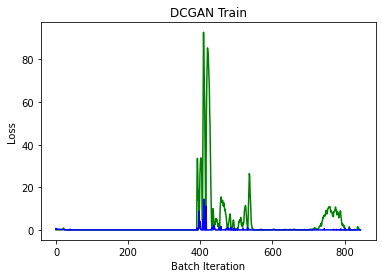

Epoch 14/100 :
     Batch 1/65 generator loss | discriminator loss : 0.0007791485986672342 | 2.6632678284954636e-09 - batch took 4.34632134437561 s.
     Batch 2/65 generator loss | discriminator loss : 0.00018412164354231209 | 2.338870217499789e-06 - batch took 4.271363019943237 s.
     Batch 3/65 generator loss | discriminator loss : 0.00048425470595248044 | 3.046474628121132e-09 - batch took 4.37030291557312 s.
     Batch 4/65 generator loss | discriminator loss : 0.00019684576545841992 | 6.1388698568976e-09 - batch took 4.392287969589233 s.
     Batch 5/65 generator loss | discriminator loss : 0.00010628226300468668 | 1.3441017188142723e-07 - batch took 4.321333885192871 s.
     Batch 6/65 generator loss | discriminator loss : 6.95041599101387e-05 | 1.2989294191356748e-06 - batch took 4.268364429473877 s.
     Batch 7/65 generator loss | discriminator loss : 0.00013694162771571428 | 7.045454367471393e-06 - batch took 4.3233301639556885 s.
     Batch 8/65 generator loss | discrimina

     Batch 62/65 generator loss | discriminator loss : 0.002177551854401827 | 0.0005691464757546782 - batch took 4.31533670425415 s.
     Batch 63/65 generator loss | discriminator loss : 0.00498345959931612 | 0.0027804141864180565 - batch took 4.392287492752075 s.
     Batch 64/65 generator loss | discriminator loss : 0.010585903190076351 | 0.0022103171795606613 - batch took 4.446256160736084 s.
     Batch 65/65 generator loss | discriminator loss : 0.0004049638519063592 | 0.0005039427778683603 - batch took 1.1662795543670654 s.


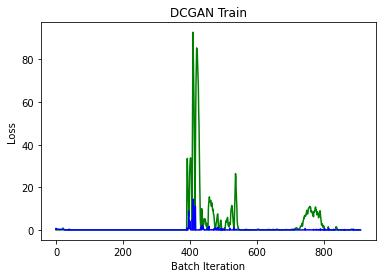

Epoch 15/100 :
     Batch 1/65 generator loss | discriminator loss : 0.013555220328271389 | 0.00032843759981915355 - batch took 4.3932483196258545 s.
     Batch 2/65 generator loss | discriminator loss : 0.012503649108111858 | 0.00421387143433094 - batch took 4.30634069442749 s.
     Batch 3/65 generator loss | discriminator loss : 0.024342726916074753 | 0.0002566309995017946 - batch took 4.259371042251587 s.
     Batch 4/65 generator loss | discriminator loss : 0.03692803904414177 | 0.00013376833521761 - batch took 4.296348571777344 s.
     Batch 5/65 generator loss | discriminator loss : 0.030919549986720085 | 5.066224548500031e-05 - batch took 4.408276796340942 s.
     Batch 6/65 generator loss | discriminator loss : 0.16813331842422485 | 0.02423139661550522 - batch took 4.29434871673584 s.
     Batch 7/65 generator loss | discriminator loss : 0.18525487184524536 | 0.00011806003021774814 - batch took 4.261369943618774 s.
     Batch 8/65 generator loss | discriminator loss : 0.045625

     Batch 63/65 generator loss | discriminator loss : 0.021383965387940407 | 0.00991109386086464 - batch took 4.300345420837402 s.
     Batch 64/65 generator loss | discriminator loss : 0.0034534113947302103 | 0.0043230922892689705 - batch took 4.270363092422485 s.
     Batch 65/65 generator loss | discriminator loss : 0.0039459168910980225 | 0.0007720696739852428 - batch took 1.185267686843872 s.


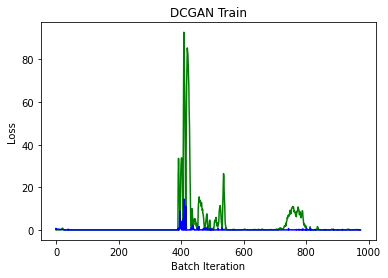

Epoch 16/100 :
     Batch 1/65 generator loss | discriminator loss : 0.018162477761507034 | 0.0039281295612454414 - batch took 4.217397689819336 s.
     Batch 2/65 generator loss | discriminator loss : 0.025293901562690735 | 0.0015745528507977724 - batch took 4.434261798858643 s.
     Batch 3/65 generator loss | discriminator loss : 0.11657208204269409 | 0.0026527990121394396 - batch took 4.448254108428955 s.
     Batch 4/65 generator loss | discriminator loss : 0.06626021862030029 | 0.00025776674738153815 - batch took 4.378297567367554 s.
     Batch 5/65 generator loss | discriminator loss : 0.1454445719718933 | 0.0005578943528234959 - batch took 4.280357837677002 s.
     Batch 6/65 generator loss | discriminator loss : 0.09822627902030945 | 0.00042094208765774965 - batch took 4.406280755996704 s.
     Batch 7/65 generator loss | discriminator loss : 0.1726008951663971 | 0.0003260461089666933 - batch took 4.331324577331543 s.
     Batch 8/65 generator loss | discriminator loss : 0.388

     Batch 63/65 generator loss | discriminator loss : 0.3755500614643097 | 0.0004944389802403748 - batch took 4.345318078994751 s.
     Batch 64/65 generator loss | discriminator loss : 0.3098147511482239 | 0.0004732115485239774 - batch took 4.286353826522827 s.
     Batch 65/65 generator loss | discriminator loss : 0.5671147704124451 | 0.0010696884710341692 - batch took 1.2252438068389893 s.


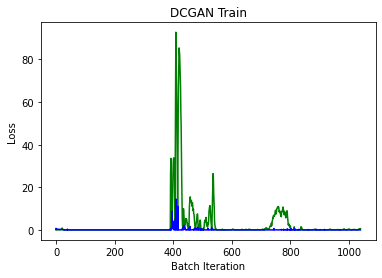

Epoch 17/100 :
     Batch 1/65 generator loss | discriminator loss : 0.17693546414375305 | 0.0007195422658696771 - batch took 4.216643571853638 s.
     Batch 2/65 generator loss | discriminator loss : 0.14621718227863312 | 0.0010687620379030704 - batch took 4.320332050323486 s.
     Batch 3/65 generator loss | discriminator loss : 0.11162891983985901 | 0.0055668530985713005 - batch took 4.567181587219238 s.
     Batch 4/65 generator loss | discriminator loss : 0.043733175843954086 | 0.06015872210264206 - batch took 4.348316431045532 s.
     Batch 5/65 generator loss | discriminator loss : 0.028362590819597244 | 0.004515784326940775 - batch took 4.2923500537872314 s.
     Batch 6/65 generator loss | discriminator loss : 0.03194258362054825 | 0.012727407738566399 - batch took 4.3203325271606445 s.
     Batch 7/65 generator loss | discriminator loss : 0.0917806625366211 | 0.00544056948274374 - batch took 4.418272495269775 s.
     Batch 8/65 generator loss | discriminator loss : 0.15599648

     Batch 64/65 generator loss | discriminator loss : 0.010282992385327816 | 0.001436712802387774 - batch took 4.3183348178863525 s.
     Batch 65/65 generator loss | discriminator loss : 0.00047238031402230263 | 1.866789698600769 - batch took 1.1622827053070068 s.


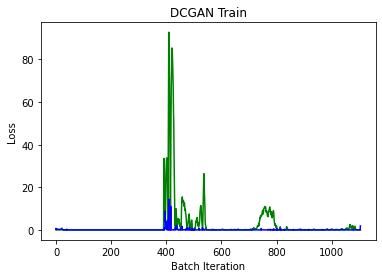

Epoch 18/100 :
     Batch 1/65 generator loss | discriminator loss : 0.00014737101446371526 | 0.016306757926940918 - batch took 4.28571629524231 s.
     Batch 2/65 generator loss | discriminator loss : 5.646239151246846e-05 | 0.0911635011434555 - batch took 4.255373239517212 s.
     Batch 3/65 generator loss | discriminator loss : 0.0007975833723321557 | 0.014157493598759174 - batch took 4.296348810195923 s.
     Batch 4/65 generator loss | discriminator loss : 0.002850067801773548 | 0.004172111861407757 - batch took 4.390289783477783 s.
     Batch 5/65 generator loss | discriminator loss : 0.0059438361786305904 | 0.0005786479450762272 - batch took 4.3023436069488525 s.
     Batch 6/65 generator loss | discriminator loss : 0.01735963672399521 | 0.00031211553141474724 - batch took 4.247379541397095 s.
     Batch 7/65 generator loss | discriminator loss : 0.08002182841300964 | 0.00013053220754954964 - batch took 4.3023436069488525 s.
     Batch 8/65 generator loss | discriminator loss : 

     Batch 62/65 generator loss | discriminator loss : 0.0004552785539999604 | 0.0003626956313382834 - batch took 4.2933509349823 s.
     Batch 63/65 generator loss | discriminator loss : 0.0010103682288900018 | 0.021346621215343475 - batch took 4.341320276260376 s.
     Batch 64/65 generator loss | discriminator loss : 0.004294254817068577 | 0.0003905760240741074 - batch took 4.440259695053101 s.
     Batch 65/65 generator loss | discriminator loss : 0.006993589922785759 | 4.777721915161237e-05 - batch took 1.1532893180847168 s.


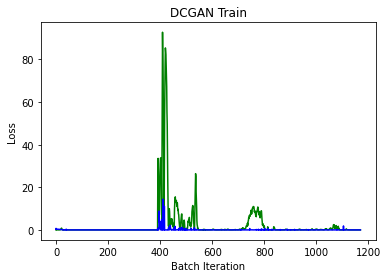

Epoch 19/100 :
     Batch 1/65 generator loss | discriminator loss : 0.013220585882663727 | 4.358125079306774e-05 - batch took 4.4227306842803955 s.
     Batch 2/65 generator loss | discriminator loss : 0.021711260080337524 | 0.00015748030273243785 - batch took 4.297348976135254 s.
     Batch 3/65 generator loss | discriminator loss : 0.0333801805973053 | 1.626294215384405e-05 - batch took 4.281357288360596 s.
     Batch 4/65 generator loss | discriminator loss : 0.05416831374168396 | 1.0084864698001184e-05 - batch took 4.32233190536499 s.
     Batch 5/65 generator loss | discriminator loss : 0.07929056137800217 | 1.5999106835806742e-05 - batch took 4.369302749633789 s.
     Batch 6/65 generator loss | discriminator loss : 0.11594069004058838 | 1.5064447325130459e-05 - batch took 4.291351079940796 s.
     Batch 7/65 generator loss | discriminator loss : 0.08500875532627106 | 1.581714786880184e-05 - batch took 4.2663655281066895 s.
     Batch 8/65 generator loss | discriminator loss : 0

     Batch 62/65 generator loss | discriminator loss : 0.013986934907734394 | 0.0002605388290248811 - batch took 4.328327178955078 s.
     Batch 63/65 generator loss | discriminator loss : 0.015786780044436455 | 0.00025746849132701755 - batch took 4.24038290977478 s.
     Batch 64/65 generator loss | discriminator loss : 0.019588209688663483 | 0.00012287737627048045 - batch took 4.311337947845459 s.
     Batch 65/65 generator loss | discriminator loss : 0.02799786441028118 | 0.00015574562712572515 - batch took 1.1852693557739258 s.


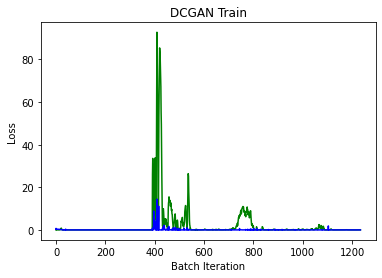

Epoch 20/100 :
     Batch 1/65 generator loss | discriminator loss : 0.0264009777456522 | 0.0009412684594281018 - batch took 4.234385251998901 s.
     Batch 2/65 generator loss | discriminator loss : 0.013670798391103745 | 0.00023572823556605726 - batch took 4.435261964797974 s.
     Batch 3/65 generator loss | discriminator loss : 0.026349395513534546 | 0.0002024004643317312 - batch took 4.3583104610443115 s.
     Batch 4/65 generator loss | discriminator loss : 0.03765649348497391 | 0.0003561178455129266 - batch took 4.298345565795898 s.
     Batch 5/65 generator loss | discriminator loss : 0.02370430901646614 | 0.00021151154942344874 - batch took 4.33432412147522 s.
     Batch 6/65 generator loss | discriminator loss : 0.018116967752575874 | 0.00032995344372466207 - batch took 4.407279968261719 s.
     Batch 7/65 generator loss | discriminator loss : 0.012627599760890007 | 0.0026287492364645004 - batch took 4.314335584640503 s.
     Batch 8/65 generator loss | discriminator loss : 0

     Batch 63/65 generator loss | discriminator loss : 0.005707668140530586 | 0.00046151987044140697 - batch took 4.3493170738220215 s.
     Batch 64/65 generator loss | discriminator loss : 0.006785624660551548 | 0.00039596130955033004 - batch took 4.321332216262817 s.
     Batch 65/65 generator loss | discriminator loss : 0.008894672617316246 | 0.0011901567922905087 - batch took 1.2072551250457764 s.


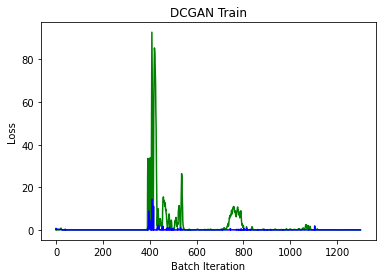

Epoch 21/100 :
     Batch 1/65 generator loss | discriminator loss : 0.004361371044069529 | 0.00033077161060646176 - batch took 4.342316389083862 s.
     Batch 2/65 generator loss | discriminator loss : 0.009765472263097763 | 0.0005911979242227972 - batch took 4.2823569774627686 s.
     Batch 3/65 generator loss | discriminator loss : 0.007780720479786396 | 0.00042324207606725395 - batch took 4.3403215408325195 s.
     Batch 4/65 generator loss | discriminator loss : 0.008938783779740334 | 0.0005082745337858796 - batch took 4.42926549911499 s.
     Batch 5/65 generator loss | discriminator loss : 0.00409652991220355 | 0.0001557158539071679 - batch took 4.302343368530273 s.
     Batch 6/65 generator loss | discriminator loss : 0.012644493021070957 | 0.00026768757379613817 - batch took 4.308340549468994 s.
     Batch 7/65 generator loss | discriminator loss : 0.008699025958776474 | 0.0025261742994189262 - batch took 4.3862926959991455 s.
     Batch 8/65 generator loss | discriminator los

     Batch 62/65 generator loss | discriminator loss : 0.01841176301240921 | 0.0002626352943480015 - batch took 4.431264638900757 s.
     Batch 63/65 generator loss | discriminator loss : 0.01156335324048996 | 0.00015330783207900822 - batch took 4.372300863265991 s.
     Batch 64/65 generator loss | discriminator loss : 0.010516494512557983 | 0.0001732722739689052 - batch took 4.5821692943573 s.
     Batch 65/65 generator loss | discriminator loss : 0.006485436111688614 | 0.00027670874260365963 - batch took 1.1732754707336426 s.


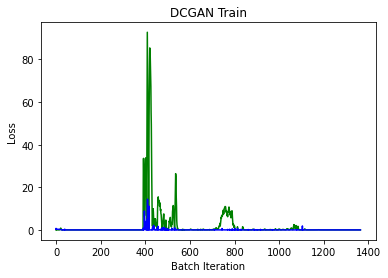

Epoch 22/100 :
     Batch 1/65 generator loss | discriminator loss : 0.013506293296813965 | 0.0001789822126738727 - batch took 4.446257591247559 s.
     Batch 2/65 generator loss | discriminator loss : 0.01231581810861826 | 0.0002140008145943284 - batch took 4.3453168869018555 s.
     Batch 3/65 generator loss | discriminator loss : 0.00833396427333355 | 0.00039472844218835235 - batch took 4.326329708099365 s.
     Batch 4/65 generator loss | discriminator loss : 0.016806062310934067 | 0.00021167697559576482 - batch took 4.314335823059082 s.
     Batch 5/65 generator loss | discriminator loss : 0.01239579264074564 | 0.00011240386083954945 - batch took 4.452252388000488 s.
     Batch 6/65 generator loss | discriminator loss : 0.011471990495920181 | 0.0007806157227605581 - batch took 4.347316026687622 s.
     Batch 7/65 generator loss | discriminator loss : 0.025610197335481644 | 0.00036064902087673545 - batch took 4.371300935745239 s.
     Batch 8/65 generator loss | discriminator loss 

     Batch 63/65 generator loss | discriminator loss : 0.1601855754852295 | 0.00420565577223897 - batch took 4.471239328384399 s.
     Batch 64/65 generator loss | discriminator loss : 0.26830199360847473 | 0.00021846723393537104 - batch took 4.368303298950195 s.
     Batch 65/65 generator loss | discriminator loss : 0.15991586446762085 | 0.0005395876942202449 - batch took 1.222245693206787 s.


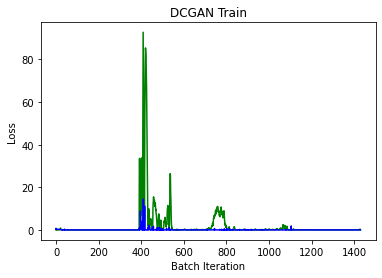

Epoch 23/100 :
     Batch 1/65 generator loss | discriminator loss : 0.1340692937374115 | 0.0009513837867416441 - batch took 4.362322807312012 s.
     Batch 2/65 generator loss | discriminator loss : 0.1452973484992981 | 0.0011310346890240908 - batch took 4.464244604110718 s.
     Batch 3/65 generator loss | discriminator loss : 0.22000131011009216 | 0.005302839446812868 - batch took 4.503219842910767 s.
     Batch 4/65 generator loss | discriminator loss : 0.1533982902765274 | 0.0013009372632950544 - batch took 4.546194553375244 s.
     Batch 5/65 generator loss | discriminator loss : 0.2232988327741623 | 0.0019800164736807346 - batch took 4.511214733123779 s.
     Batch 6/65 generator loss | discriminator loss : 0.2244213968515396 | 0.0023969546891748905 - batch took 4.613153457641602 s.
     Batch 7/65 generator loss | discriminator loss : 0.19339197874069214 | 0.002218821318820119 - batch took 4.577173709869385 s.
     Batch 8/65 generator loss | discriminator loss : 0.434265732765

     Batch 64/65 generator loss | discriminator loss : 3.692272663116455 | 0.0017088307067751884 - batch took 4.366305112838745 s.
     Batch 65/65 generator loss | discriminator loss : 5.10910701751709 | 0.008537600748240948 - batch took 1.2062556743621826 s.


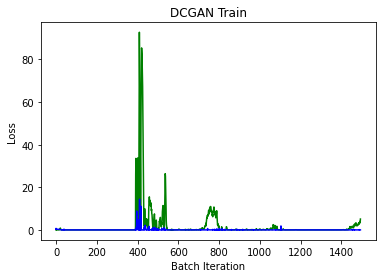

Epoch 24/100 :
     Batch 1/65 generator loss | discriminator loss : 4.583826065063477 | 0.0016349765937775373 - batch took 4.447252035140991 s.
     Batch 2/65 generator loss | discriminator loss : 5.4208526611328125 | 0.0014170472277328372 - batch took 4.363306045532227 s.
     Batch 3/65 generator loss | discriminator loss : 4.87811279296875 | 0.007003142032772303 - batch took 4.8799872398376465 s.
     Batch 4/65 generator loss | discriminator loss : 4.659911155700684 | 0.00070746592245996 - batch took 4.7580626010894775 s.
     Batch 5/65 generator loss | discriminator loss : 4.4979448318481445 | 0.2219434529542923 - batch took 4.638137102127075 s.
     Batch 6/65 generator loss | discriminator loss : 3.9332032203674316 | 0.001919346395879984 - batch took 4.45325231552124 s.
     Batch 7/65 generator loss | discriminator loss : 4.231567859649658 | 0.26595455408096313 - batch took 4.697099447250366 s.
     Batch 8/65 generator loss | discriminator loss : 3.4457943439483643 | 0.0195

     Batch 64/65 generator loss | discriminator loss : 0.08180708438158035 | 9.647834667703137e-05 - batch took 4.460247039794922 s.
     Batch 65/65 generator loss | discriminator loss : 0.06476834416389465 | 0.00010521315562073141 - batch took 1.3531646728515625 s.


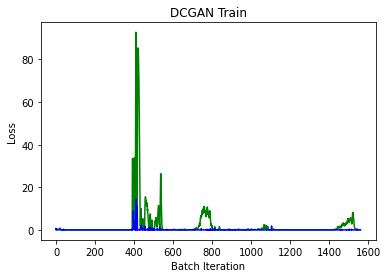

Epoch 25/100 :
     Batch 1/65 generator loss | discriminator loss : 0.036408327519893646 | 0.00016801379388198256 - batch took 4.274362087249756 s.
     Batch 2/65 generator loss | discriminator loss : 0.0402371771633625 | 0.00034982964280061424 - batch took 4.46124529838562 s.
     Batch 3/65 generator loss | discriminator loss : 0.06669695675373077 | 0.001233230228535831 - batch took 4.505218744277954 s.
     Batch 4/65 generator loss | discriminator loss : 0.03706597909331322 | 0.0016710476484149694 - batch took 4.796038389205933 s.
     Batch 5/65 generator loss | discriminator loss : 0.038357287645339966 | 0.0014735294971615076 - batch took 4.408280372619629 s.
     Batch 6/65 generator loss | discriminator loss : 0.060393985360860825 | 0.000436444825027138 - batch took 4.497222661972046 s.
     Batch 7/65 generator loss | discriminator loss : 0.024164892733097076 | 0.00045623848563991487 - batch took 4.702097654342651 s.
     Batch 8/65 generator loss | discriminator loss : 0.04

     Batch 64/65 generator loss | discriminator loss : 8.805681228637695 | 0.09350042790174484 - batch took 4.47024130821228 s.
     Batch 65/65 generator loss | discriminator loss : 9.019454002380371 | 1.1068138974223984e-06 - batch took 1.200258731842041 s.


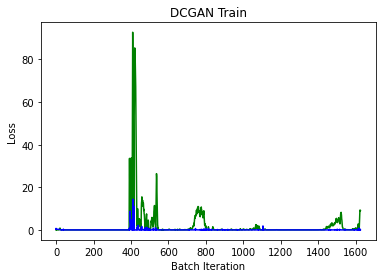

Epoch 26/100 :
     Batch 1/65 generator loss | discriminator loss : 8.794734954833984 | 1.3491162462742068e-05 - batch took 4.56318211555481 s.
     Batch 2/65 generator loss | discriminator loss : 8.197580337524414 | 4.322999302530661e-06 - batch took 4.433265209197998 s.
     Batch 3/65 generator loss | discriminator loss : 7.124248504638672 | 5.524027437786572e-05 - batch took 4.324329137802124 s.
     Batch 4/65 generator loss | discriminator loss : 5.909341812133789 | 1.5612667993991636e-05 - batch took 4.474238157272339 s.
     Batch 5/65 generator loss | discriminator loss : 5.4516496658325195 | 2.273906147820526e-06 - batch took 4.517211198806763 s.
     Batch 6/65 generator loss | discriminator loss : 4.027825355529785 | 2.151004082406871e-05 - batch took 4.444256544113159 s.
     Batch 7/65 generator loss | discriminator loss : 3.0739126205444336 | 0.00013647539890371263 - batch took 4.416273355484009 s.
     Batch 8/65 generator loss | discriminator loss : 1.745641469955444

     Batch 64/65 generator loss | discriminator loss : 1.4066004753112793 | 5.260955049379845e-07 - batch took 4.304342985153198 s.
     Batch 65/65 generator loss | discriminator loss : 1.7454676628112793 | 1.6045933678987545e-11 - batch took 1.247229814529419 s.


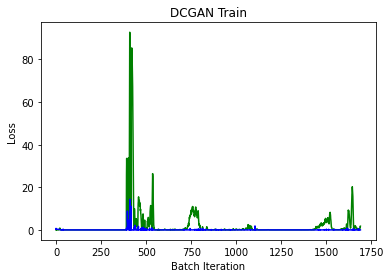

Epoch 27/100 :
     Batch 1/65 generator loss | discriminator loss : 1.2309441566467285 | 5.76810897223029e-13 - batch took 4.251904487609863 s.
     Batch 2/65 generator loss | discriminator loss : 1.0957627296447754 | 3.177959536694065e-14 - batch took 4.396285772323608 s.
     Batch 3/65 generator loss | discriminator loss : 0.33205142617225647 | 1.82428360612219e-11 - batch took 4.388290166854858 s.
     Batch 4/65 generator loss | discriminator loss : 0.06066112220287323 | 3.7985743091034814e-15 - batch took 4.371302366256714 s.
     Batch 5/65 generator loss | discriminator loss : 0.005783704109489918 | 2.476466627997372e-15 - batch took 4.302343130111694 s.
     Batch 6/65 generator loss | discriminator loss : 0.009396886453032494 | 4.698955113902059e-10 - batch took 4.421272039413452 s.
     Batch 7/65 generator loss | discriminator loss : 0.0005450882017612457 | 1.4694906749768144e-11 - batch took 4.3263280391693115 s.
     Batch 8/65 generator loss | discriminator loss : 0.00

     Batch 62/65 generator loss | discriminator loss : 1.9634670024970546e-05 | 0.0001321502058999613 - batch took 4.51221489906311 s.
     Batch 63/65 generator loss | discriminator loss : 1.300200665355078e-06 | 0.0001332643732894212 - batch took 4.573178291320801 s.
     Batch 64/65 generator loss | discriminator loss : 1.0393729326096945e-06 | 0.06490878760814667 - batch took 4.517211198806763 s.
     Batch 65/65 generator loss | discriminator loss : 1.1216004622838227e-06 | 3.737470251508057e-05 - batch took 1.2172484397888184 s.


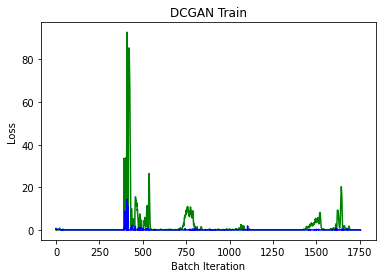

Epoch 28/100 :
     Batch 1/65 generator loss | discriminator loss : 2.63072115558316e-06 | 0.0006304393173195422 - batch took 4.523388385772705 s.
     Batch 2/65 generator loss | discriminator loss : 4.640804007749466e-08 | 0.00022314078523777425 - batch took 4.297346830368042 s.
     Batch 3/65 generator loss | discriminator loss : 5.725926754962529e-08 | 9.133134153671563e-05 - batch took 4.432263374328613 s.
     Batch 4/65 generator loss | discriminator loss : 1.953955575118016e-07 | 0.0008360909996554255 - batch took 4.354312181472778 s.
     Batch 5/65 generator loss | discriminator loss : 8.163704023900209e-08 | 0.0016617666697129607 - batch took 4.28435492515564 s.
     Batch 6/65 generator loss | discriminator loss : 8.288166668535268e-07 | 9.829388000071049e-05 - batch took 4.319334268569946 s.
     Batch 7/65 generator loss | discriminator loss : 6.5286949180176634e-09 | 0.00018101079331245273 - batch took 4.388291120529175 s.
     Batch 8/65 generator loss | discriminator

     Batch 62/65 generator loss | discriminator loss : 0.015628546476364136 | 0.0007743960595689714 - batch took 4.518211603164673 s.
     Batch 63/65 generator loss | discriminator loss : 0.0067555662244558334 | 0.0001289072388317436 - batch took 4.414273738861084 s.
     Batch 64/65 generator loss | discriminator loss : 0.0022396338172256947 | 0.0008880589157342911 - batch took 4.3653059005737305 s.
     Batch 65/65 generator loss | discriminator loss : 0.0009567577508278191 | 1.5774794519529678e-05 - batch took 1.2292418479919434 s.


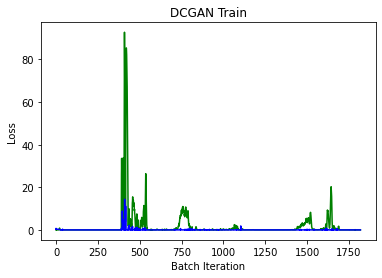

Epoch 29/100 :
     Batch 1/65 generator loss | discriminator loss : 0.0021627373062074184 | 0.00013586498971562833 - batch took 4.458853721618652 s.
     Batch 2/65 generator loss | discriminator loss : 0.008126751519739628 | 0.0017208917997777462 - batch took 4.508216857910156 s.
     Batch 3/65 generator loss | discriminator loss : 0.009222408756613731 | 4.8560214054305106e-05 - batch took 4.457247257232666 s.
     Batch 4/65 generator loss | discriminator loss : 0.0018833900103345513 | 0.0002206507488153875 - batch took 4.432263612747192 s.
     Batch 5/65 generator loss | discriminator loss : 0.015328583307564259 | 0.0004569899174384773 - batch took 4.396286487579346 s.
     Batch 6/65 generator loss | discriminator loss : 0.0029033152386546135 | 0.0008791508735157549 - batch took 4.347316741943359 s.
     Batch 7/65 generator loss | discriminator loss : 0.004200039431452751 | 3.990585173596628e-05 - batch took 4.471240282058716 s.
     Batch 8/65 generator loss | discriminator lo

     Batch 63/65 generator loss | discriminator loss : 0.17292660474777222 | 0.0035068064462393522 - batch took 4.433263301849365 s.
     Batch 64/65 generator loss | discriminator loss : 0.17124369740486145 | 0.0010432956041768193 - batch took 4.6351377964019775 s.
     Batch 65/65 generator loss | discriminator loss : 0.20690761506557465 | 0.0001986650750041008 - batch took 1.2062559127807617 s.


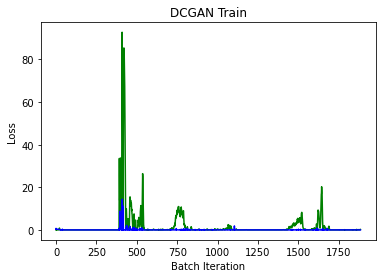

Epoch 30/100 :
     Batch 1/65 generator loss | discriminator loss : 0.1680915206670761 | 0.0010182433761656284 - batch took 4.608152866363525 s.
     Batch 2/65 generator loss | discriminator loss : 0.15283656120300293 | 0.0015474265674129128 - batch took 4.537198305130005 s.
     Batch 3/65 generator loss | discriminator loss : 0.1643429696559906 | 0.0018693659221753478 - batch took 4.525207042694092 s.
     Batch 4/65 generator loss | discriminator loss : 0.23272916674613953 | 0.0022687073796987534 - batch took 4.544194459915161 s.
     Batch 5/65 generator loss | discriminator loss : 0.23867161571979523 | 0.0020035593770444393 - batch took 4.419272184371948 s.
     Batch 6/65 generator loss | discriminator loss : 0.1319381594657898 | 0.002022029832005501 - batch took 4.377298355102539 s.
     Batch 7/65 generator loss | discriminator loss : 0.21165424585342407 | 0.004154875874519348 - batch took 4.397284746170044 s.
     Batch 8/65 generator loss | discriminator loss : 0.3103436827

     Batch 64/65 generator loss | discriminator loss : 24.673324584960938 | 1.540344563011331e-08 - batch took 4.264366388320923 s.
     Batch 65/65 generator loss | discriminator loss : 31.200016021728516 | 0.0014206751948222518 - batch took 1.250227928161621 s.


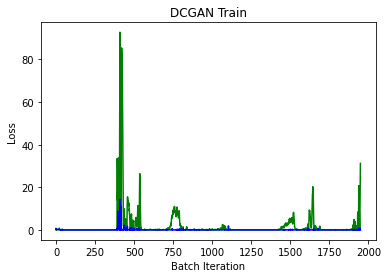

Epoch 31/100 :
     Batch 1/65 generator loss | discriminator loss : 31.608474731445312 | 0.30920496582984924 - batch took 4.251378536224365 s.
     Batch 2/65 generator loss | discriminator loss : 29.36489486694336 | 0.0009194134618155658 - batch took 4.311337947845459 s.
     Batch 3/65 generator loss | discriminator loss : 19.65154266357422 | 0.2725237011909485 - batch took 4.460248231887817 s.
     Batch 4/65 generator loss | discriminator loss : 6.467672348022461 | 0.2977006137371063 - batch took 4.407278537750244 s.
     Batch 5/65 generator loss | discriminator loss : 0.003355095162987709 | 0.2766400873661041 - batch took 4.248377084732056 s.
     Batch 6/65 generator loss | discriminator loss : 3.5004822507289646e-07 | 0.1927177906036377 - batch took 4.307340145111084 s.
     Batch 7/65 generator loss | discriminator loss : 0.48205074667930603 | 1.7561782598495483 - batch took 4.4552483558654785 s.
     Batch 8/65 generator loss | discriminator loss : 13.054178237915039 | 2.307

     Batch 64/65 generator loss | discriminator loss : 40.77392578125 | 0.49351587891578674 - batch took 4.335324048995972 s.
     Batch 65/65 generator loss | discriminator loss : 35.31296920776367 | 3.7834607269360276e-07 - batch took 1.1702778339385986 s.


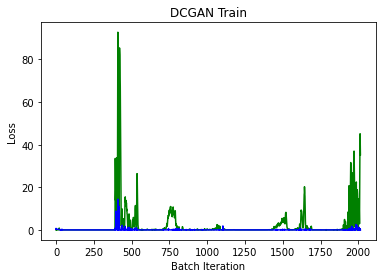

Epoch 32/100 :
     Batch 1/65 generator loss | discriminator loss : 27.175722122192383 | 0.05628592520952225 - batch took 4.35380744934082 s.
     Batch 2/65 generator loss | discriminator loss : 19.912490844726562 | 0.00032857334008440375 - batch took 4.2773597240448 s.
     Batch 3/65 generator loss | discriminator loss : 12.781514167785645 | 6.766161959603778e-07 - batch took 4.302344799041748 s.
     Batch 4/65 generator loss | discriminator loss : 6.9935407638549805 | 4.256034571881173e-06 - batch took 4.489228010177612 s.
     Batch 5/65 generator loss | discriminator loss : 1.7497248649597168 | 0.0002472150372341275 - batch took 4.3503148555755615 s.
     Batch 6/65 generator loss | discriminator loss : 0.3056611120700836 | 0.028787150979042053 - batch took 4.247377157211304 s.
     Batch 7/65 generator loss | discriminator loss : 9.05404281616211 | 0.4221355617046356 - batch took 4.408279180526733 s.
     Batch 8/65 generator loss | discriminator loss : 18.595386505126953 | 0.

     Batch 63/65 generator loss | discriminator loss : 0.03317466005682945 | 0.00021274187020026147 - batch took 4.326328754425049 s.
     Batch 64/65 generator loss | discriminator loss : 0.0009272399474866688 | 1.1032125257770531e-05 - batch took 4.40927791595459 s.
     Batch 65/65 generator loss | discriminator loss : 6.927373760845512e-05 | 3.2092480068968143e-06 - batch took 1.1782736778259277 s.


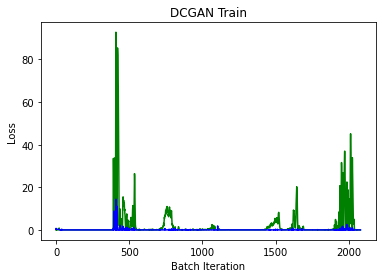

Epoch 33/100 :
     Batch 1/65 generator loss | discriminator loss : 0.07633844763040543 | 0.003834961447864771 - batch took 4.477240800857544 s.
     Batch 2/65 generator loss | discriminator loss : 0.10026606172323227 | 0.00011774560698540881 - batch took 4.312338352203369 s.
     Batch 3/65 generator loss | discriminator loss : 0.0452454537153244 | 0.0006149038090370595 - batch took 4.304342031478882 s.
     Batch 4/65 generator loss | discriminator loss : 0.03706199675798416 | 8.70485237101093e-05 - batch took 4.32932710647583 s.
     Batch 5/65 generator loss | discriminator loss : 0.10076892375946045 | 0.003060603514313698 - batch took 4.435261964797974 s.
     Batch 6/65 generator loss | discriminator loss : 0.0028747492469847202 | 0.002992793219164014 - batch took 4.367302894592285 s.
     Batch 7/65 generator loss | discriminator loss : 0.018233338370919228 | 0.0002206750650657341 - batch took 4.302344799041748 s.
     Batch 8/65 generator loss | discriminator loss : 0.3229776

     Batch 63/65 generator loss | discriminator loss : 0.007397528737783432 | 5.197828431846574e-05 - batch took 4.3273303508758545 s.
     Batch 64/65 generator loss | discriminator loss : 0.045503657311201096 | 0.00012580717157106847 - batch took 4.4212706089019775 s.
     Batch 65/65 generator loss | discriminator loss : 9.293625771533698e-05 | 5.798941492685117e-05 - batch took 1.258223295211792 s.


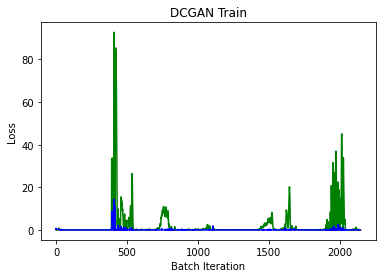

Epoch 34/100 :
     Batch 1/65 generator loss | discriminator loss : 0.16050931811332703 | 3.036424095625989e-05 - batch took 4.436259984970093 s.
     Batch 2/65 generator loss | discriminator loss : 0.19573739171028137 | 5.28120799572207e-05 - batch took 4.59916090965271 s.
     Batch 3/65 generator loss | discriminator loss : 0.23281335830688477 | 0.009909277781844139 - batch took 4.621147871017456 s.
     Batch 4/65 generator loss | discriminator loss : 0.0097800949588418 | 0.0028687731828540564 - batch took 4.447254180908203 s.
     Batch 5/65 generator loss | discriminator loss : 0.016488168388605118 | 8.535091183148324e-05 - batch took 4.378297567367554 s.
     Batch 6/65 generator loss | discriminator loss : 0.04897863790392876 | 0.00018299926887266338 - batch took 4.426267147064209 s.
     Batch 7/65 generator loss | discriminator loss : 0.19573739171028137 | 0.00041872344445437193 - batch took 4.4542505741119385 s.
     Batch 8/65 generator loss | discriminator loss : 0.00867

     Batch 63/65 generator loss | discriminator loss : 1.1910645961761475 | 2.5529704998916714e-06 - batch took 4.401283025741577 s.
     Batch 64/65 generator loss | discriminator loss : 1.2449766397476196 | 3.852776899293531e-06 - batch took 4.536199569702148 s.
     Batch 65/65 generator loss | discriminator loss : 0.0800756961107254 | 4.8529736886848696e-06 - batch took 1.2892053127288818 s.


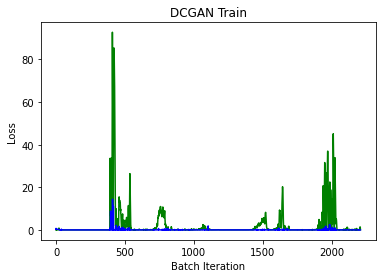

Epoch 35/100 :
     Batch 1/65 generator loss | discriminator loss : 0.6931106448173523 | 4.6505472710123286e-05 - batch took 4.363304853439331 s.
     Batch 2/65 generator loss | discriminator loss : 0.6729644536972046 | 8.892974437912926e-05 - batch took 4.36130690574646 s.
     Batch 3/65 generator loss | discriminator loss : 0.31316882371902466 | 0.0005248697707429528 - batch took 4.452250242233276 s.
     Batch 4/65 generator loss | discriminator loss : 0.12575285136699677 | 0.0005344414967112243 - batch took 4.313337564468384 s.
     Batch 5/65 generator loss | discriminator loss : 0.018612856045365334 | 0.0016280184499919415 - batch took 4.427267551422119 s.
     Batch 6/65 generator loss | discriminator loss : 0.09820082783699036 | 0.0010323298629373312 - batch took 4.303343057632446 s.
     Batch 7/65 generator loss | discriminator loss : 0.00484310369938612 | 0.009736503474414349 - batch took 4.455250024795532 s.
     Batch 8/65 generator loss | discriminator loss : 0.0202473

     Batch 63/65 generator loss | discriminator loss : 1.245640754699707 | 0.004621820989996195 - batch took 4.402281284332275 s.
     Batch 64/65 generator loss | discriminator loss : 0.7339364290237427 | 0.009270264767110348 - batch took 4.335324764251709 s.
     Batch 65/65 generator loss | discriminator loss : 1.6122751235961914 | 0.006027556490153074 - batch took 1.200258731842041 s.


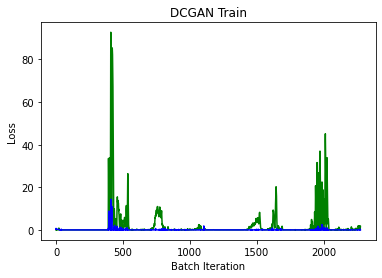

Epoch 36/100 :
     Batch 1/65 generator loss | discriminator loss : 0.8826280832290649 | 0.00553217763081193 - batch took 4.408276557922363 s.
     Batch 2/65 generator loss | discriminator loss : 0.2963331937789917 | 0.054076049476861954 - batch took 4.396285533905029 s.
     Batch 3/65 generator loss | discriminator loss : 0.08047080039978027 | 0.002720191376283765 - batch took 4.352312803268433 s.
     Batch 4/65 generator loss | discriminator loss : 0.25243431329727173 | 0.03509035333991051 - batch took 4.511214733123779 s.
     Batch 5/65 generator loss | discriminator loss : 0.975692868232727 | 0.004750375635921955 - batch took 4.440259695053101 s.
     Batch 6/65 generator loss | discriminator loss : 1.9800448417663574 | 0.002021273598074913 - batch took 4.409277439117432 s.
     Batch 7/65 generator loss | discriminator loss : 1.798620343208313 | 0.02359900437295437 - batch took 4.330327033996582 s.
     Batch 8/65 generator loss | discriminator loss : 1.128071665763855 | 0.00

     Batch 64/65 generator loss | discriminator loss : 0.4182451367378235 | 0.0006805974408052862 - batch took 4.446256637573242 s.
     Batch 65/65 generator loss | discriminator loss : 0.043620578944683075 | 0.0052869319915771484 - batch took 1.1692774295806885 s.


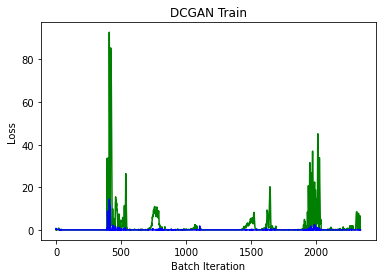

Epoch 37/100 :
     Batch 1/65 generator loss | discriminator loss : 0.028506362810730934 | 0.011573705822229385 - batch took 4.468245506286621 s.
     Batch 2/65 generator loss | discriminator loss : 0.1924671083688736 | 0.029383312910795212 - batch took 4.465243816375732 s.
     Batch 3/65 generator loss | discriminator loss : 1.5821740627288818 | 0.0280571598559618 - batch took 4.492226600646973 s.
     Batch 4/65 generator loss | discriminator loss : 2.433915615081787 | 0.15220072865486145 - batch took 4.3852925300598145 s.
     Batch 5/65 generator loss | discriminator loss : 2.783304452896118 | 0.00016265707381535321 - batch took 4.483232259750366 s.
     Batch 6/65 generator loss | discriminator loss : 2.868438482284546 | 0.0001002718709059991 - batch took 4.503219842910767 s.
     Batch 7/65 generator loss | discriminator loss : 2.064520835876465 | 0.000531196768861264 - batch took 4.394287586212158 s.
     Batch 8/65 generator loss | discriminator loss : 2.190919876098633 | 0.

     Batch 63/65 generator loss | discriminator loss : 0.3996090590953827 | 0.00025794055545702577 - batch took 4.381295919418335 s.
     Batch 64/65 generator loss | discriminator loss : 0.2738548815250397 | 0.0025755465030670166 - batch took 4.294349431991577 s.
     Batch 65/65 generator loss | discriminator loss : 0.2438497543334961 | 6.507374928332865e-05 - batch took 1.19026517868042 s.


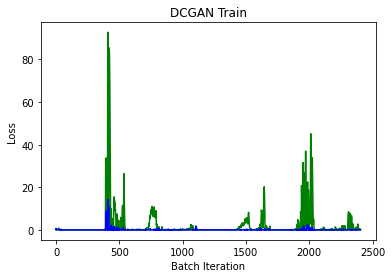

Epoch 38/100 :
     Batch 1/65 generator loss | discriminator loss : 0.3320953845977783 | 0.00679850485175848 - batch took 4.2503767013549805 s.
     Batch 2/65 generator loss | discriminator loss : 0.30642247200012207 | 0.00032633397495374084 - batch took 4.481233596801758 s.
     Batch 3/65 generator loss | discriminator loss : 0.11740605533123016 | 0.0002549049095250666 - batch took 4.410277366638184 s.
     Batch 4/65 generator loss | discriminator loss : 0.1489930897951126 | 0.0003556730807758868 - batch took 4.361307621002197 s.
     Batch 5/65 generator loss | discriminator loss : 0.201803058385849 | 0.0005098714027553797 - batch took 4.310338973999023 s.
     Batch 6/65 generator loss | discriminator loss : 0.08376196026802063 | 0.0005278487224131823 - batch took 4.495225667953491 s.
     Batch 7/65 generator loss | discriminator loss : 0.08645592629909515 | 0.00024077645502984524 - batch took 4.6092848777771 s.
     Batch 8/65 generator loss | discriminator loss : 0.1315798163

     Batch 63/65 generator loss | discriminator loss : 0.04066547751426697 | 7.989094228832982e-06 - batch took 4.441259145736694 s.
     Batch 64/65 generator loss | discriminator loss : 0.0044221775606274605 | 1.6052155842771754e-05 - batch took 4.39628529548645 s.
     Batch 65/65 generator loss | discriminator loss : 0.002620717976242304 | 3.186085814377293e-05 - batch took 1.2022583484649658 s.


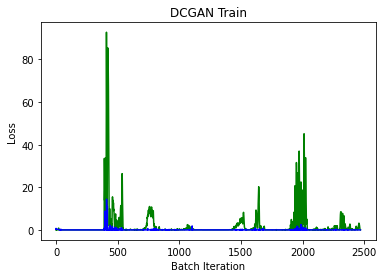

Epoch 39/100 :
     Batch 1/65 generator loss | discriminator loss : 0.001810737419873476 | 7.201644621090963e-05 - batch took 4.465386390686035 s.
     Batch 2/65 generator loss | discriminator loss : 0.0005843752296641469 | 0.0007088376441970468 - batch took 4.37929630279541 s.
     Batch 3/65 generator loss | discriminator loss : 0.000311599753331393 | 0.0006061299936845899 - batch took 4.399282932281494 s.
     Batch 4/65 generator loss | discriminator loss : 0.00011591898510232568 | 0.0007790711242705584 - batch took 4.348315477371216 s.
     Batch 5/65 generator loss | discriminator loss : 9.487925126450136e-05 | 0.002357598626986146 - batch took 4.330327272415161 s.
     Batch 6/65 generator loss | discriminator loss : 8.412662282353267e-05 | 0.0012103632325306535 - batch took 4.379295825958252 s.
     Batch 7/65 generator loss | discriminator loss : 0.00017686006322037429 | 0.003209766000509262 - batch took 4.520209789276123 s.
     Batch 8/65 generator loss | discriminator los

     Batch 63/65 generator loss | discriminator loss : 0.1320376694202423 | 0.0010329504730179906 - batch took 4.640135049819946 s.
     Batch 64/65 generator loss | discriminator loss : 0.10189497470855713 | 0.0007446836680173874 - batch took 4.435261964797974 s.
     Batch 65/65 generator loss | discriminator loss : 0.10306517779827118 | 0.00019302451983094215 - batch took 1.1662797927856445 s.


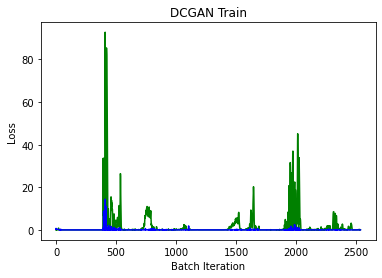

Epoch 40/100 :
     Batch 1/65 generator loss | discriminator loss : 0.17641064524650574 | 0.0005601792363449931 - batch took 4.38329815864563 s.
     Batch 2/65 generator loss | discriminator loss : 0.16573677957057953 | 0.0006807727040722966 - batch took 4.3842933177948 s.
     Batch 3/65 generator loss | discriminator loss : 0.3087715208530426 | 0.0009237158228643239 - batch took 4.2883524894714355 s.
     Batch 4/65 generator loss | discriminator loss : 0.1939881443977356 | 0.000328349502524361 - batch took 4.412276268005371 s.
     Batch 5/65 generator loss | discriminator loss : 0.6090420484542847 | 0.0007857324089854956 - batch took 4.365305185317993 s.
     Batch 6/65 generator loss | discriminator loss : 0.304122656583786 | 0.0079781049862504 - batch took 4.3003456592559814 s.
     Batch 7/65 generator loss | discriminator loss : 0.2947094440460205 | 0.0008656514692120254 - batch took 4.3443169593811035 s.
     Batch 8/65 generator loss | discriminator loss : 0.383283972740173

     Batch 63/65 generator loss | discriminator loss : 0.03669506683945656 | 0.0004817810549866408 - batch took 4.580172300338745 s.
     Batch 64/65 generator loss | discriminator loss : 0.0800870805978775 | 0.00031739845871925354 - batch took 4.435262680053711 s.
     Batch 65/65 generator loss | discriminator loss : 0.0658627599477768 | 0.00036761967930942774 - batch took 1.1882665157318115 s.


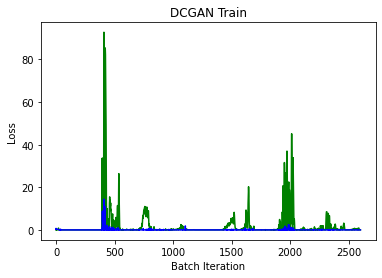

Epoch 41/100 :
     Batch 1/65 generator loss | discriminator loss : 0.11059410870075226 | 0.004368894267827272 - batch took 4.490617513656616 s.
     Batch 2/65 generator loss | discriminator loss : 0.13327595591545105 | 0.0001126851566368714 - batch took 4.475238561630249 s.
     Batch 3/65 generator loss | discriminator loss : 0.15773174166679382 | 0.00019098972552455962 - batch took 4.3473169803619385 s.
     Batch 4/65 generator loss | discriminator loss : 0.150702565908432 | 0.00020287009829189628 - batch took 4.342413663864136 s.
     Batch 5/65 generator loss | discriminator loss : 0.10709233582019806 | 9.419289563084021e-05 - batch took 4.4112749099731445 s.
     Batch 6/65 generator loss | discriminator loss : 0.1331196427345276 | 2.6620393327903003e-05 - batch took 4.469241380691528 s.
     Batch 7/65 generator loss | discriminator loss : 0.05890296772122383 | 0.0020736688748002052 - batch took 4.362307786941528 s.
     Batch 8/65 generator loss | discriminator loss : 0.0415

     Batch 63/65 generator loss | discriminator loss : 0.0016894092550501227 | 0.017395922914147377 - batch took 4.353312730789185 s.
     Batch 64/65 generator loss | discriminator loss : 0.009291958063840866 | 0.008115342818200588 - batch took 4.381295442581177 s.
     Batch 65/65 generator loss | discriminator loss : 0.022456448525190353 | 0.0014309696853160858 - batch took 1.210252285003662 s.


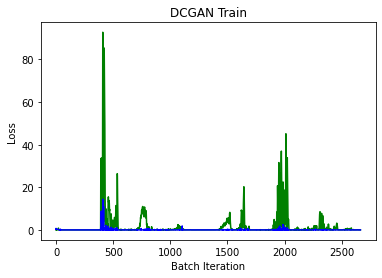

Epoch 42/100 :
     Batch 1/65 generator loss | discriminator loss : 0.18997284770011902 | 0.0005230048554949462 - batch took 4.281358003616333 s.
     Batch 2/65 generator loss | discriminator loss : 0.5747705101966858 | 0.00011785479728132486 - batch took 4.537199258804321 s.
     Batch 3/65 generator loss | discriminator loss : 0.9653851985931396 | 6.797546120651532e-06 - batch took 4.434262990951538 s.
     Batch 4/65 generator loss | discriminator loss : 1.6301023960113525 | 1.5837294995435514e-06 - batch took 4.490227222442627 s.
     Batch 5/65 generator loss | discriminator loss : 1.580657720565796 | 0.0010727227199822664 - batch took 4.32732892036438 s.
     Batch 6/65 generator loss | discriminator loss : 1.3293447494506836 | 1.9335013234922371e-07 - batch took 4.493226051330566 s.
     Batch 7/65 generator loss | discriminator loss : 0.8957653045654297 | 0.00015186952077783644 - batch took 4.482232570648193 s.
     Batch 8/65 generator loss | discriminator loss : 0.754080414

     Batch 63/65 generator loss | discriminator loss : 6.869443313917145e-05 | 5.938091271673329e-05 - batch took 4.44125771522522 s.
     Batch 64/65 generator loss | discriminator loss : 7.371946412604302e-05 | 0.001597813330590725 - batch took 4.374299764633179 s.
     Batch 65/65 generator loss | discriminator loss : 0.0002890457399189472 | 7.574738901894307e-06 - batch took 1.1982598304748535 s.


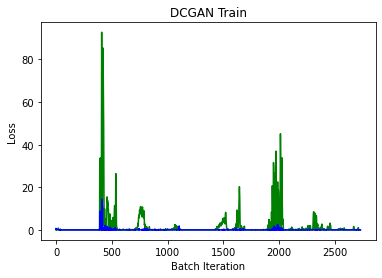

Epoch 43/100 :
     Batch 1/65 generator loss | discriminator loss : 0.0001419941836502403 | 8.930872354540043e-06 - batch took 4.277358293533325 s.
     Batch 2/65 generator loss | discriminator loss : 0.00016182611580006778 | 9.614297596272081e-06 - batch took 4.459247589111328 s.
     Batch 3/65 generator loss | discriminator loss : 0.0002533794322516769 | 0.0012923304457217455 - batch took 4.3882904052734375 s.
     Batch 4/65 generator loss | discriminator loss : 0.00012871914077550173 | 0.006922293454408646 - batch took 4.370303153991699 s.
     Batch 5/65 generator loss | discriminator loss : 8.029652963159606e-05 | 1.9330604118295014e-05 - batch took 4.355310678482056 s.
     Batch 6/65 generator loss | discriminator loss : 9.699387737782672e-05 | 1.4301145711215213e-05 - batch took 4.4802350997924805 s.
     Batch 7/65 generator loss | discriminator loss : 5.5805485317250714e-05 | 4.74091139039956e-05 - batch took 4.395286798477173 s.
     Batch 8/65 generator loss | discrimin

     Batch 63/65 generator loss | discriminator loss : 0.0003991763514932245 | 0.003930818755179644 - batch took 4.473237752914429 s.
     Batch 64/65 generator loss | discriminator loss : 0.025583744049072266 | 0.05614987015724182 - batch took 4.373301982879639 s.
     Batch 65/65 generator loss | discriminator loss : 0.0006572518032044172 | 0.12883712351322174 - batch took 1.1772725582122803 s.


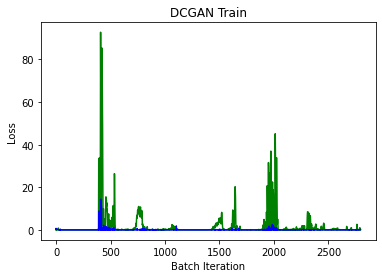

Epoch 44/100 :
     Batch 1/65 generator loss | discriminator loss : 0.0008726712549105287 | 0.028830599039793015 - batch took 4.419269800186157 s.
     Batch 2/65 generator loss | discriminator loss : 0.07101864367723465 | 0.03268834948539734 - batch took 4.468240976333618 s.
     Batch 3/65 generator loss | discriminator loss : 1.7462879419326782 | 0.00036196070141159 - batch took 4.346316337585449 s.
     Batch 4/65 generator loss | discriminator loss : 3.986497402191162 | 0.009119869209825993 - batch took 4.52220892906189 s.
     Batch 5/65 generator loss | discriminator loss : 5.964288711547852 | 0.005659280810505152 - batch took 4.453250885009766 s.
     Batch 6/65 generator loss | discriminator loss : 0.00013620679965242743 | 0.3083089292049408 - batch took 4.379853963851929 s.
     Batch 7/65 generator loss | discriminator loss : 2.958278179168701 | 0.3145158290863037 - batch took 4.2723612785339355 s.
     Batch 8/65 generator loss | discriminator loss : 11.391632080078125 | 0

     Batch 64/65 generator loss | discriminator loss : 3.558079242706299 | 0.125254824757576 - batch took 4.465244293212891 s.
     Batch 65/65 generator loss | discriminator loss : 4.179704666137695 | 0.0010921121574938297 - batch took 1.183267593383789 s.


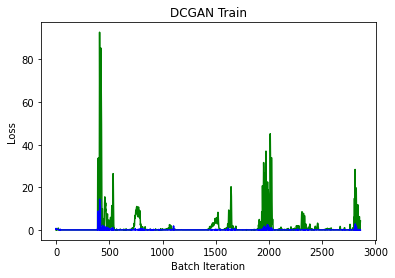

Epoch 45/100 :
     Batch 1/65 generator loss | discriminator loss : 3.8561925888061523 | 0.11580700427293777 - batch took 4.44225549697876 s.
     Batch 2/65 generator loss | discriminator loss : 3.773897647857666 | 0.0030109514482319355 - batch took 4.354310750961304 s.
     Batch 3/65 generator loss | discriminator loss : 3.1592915058135986 | 0.08032909780740738 - batch took 4.350314617156982 s.
     Batch 4/65 generator loss | discriminator loss : 2.853659152984619 | 0.002417108742520213 - batch took 4.36830472946167 s.
     Batch 5/65 generator loss | discriminator loss : 2.2304093837738037 | 0.03424552455544472 - batch took 4.522207975387573 s.
     Batch 6/65 generator loss | discriminator loss : 1.6180812120437622 | 0.01258110161870718 - batch took 4.410276412963867 s.
     Batch 7/65 generator loss | discriminator loss : 1.555391550064087 | 0.011813627555966377 - batch took 4.4302659034729 s.
     Batch 8/65 generator loss | discriminator loss : 1.4057037830352783 | 0.25335034

     Batch 65/65 generator loss | discriminator loss : 1.9813976287841797 | 0.5737716555595398 - batch took 1.2092533111572266 s.


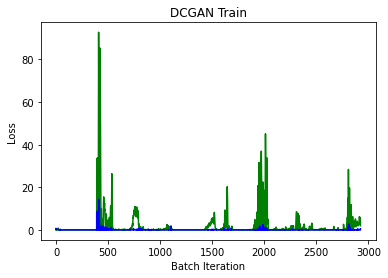

Epoch 46/100 :
     Batch 1/65 generator loss | discriminator loss : 3.52435040473938 | 0.14453405141830444 - batch took 4.601705312728882 s.
     Batch 2/65 generator loss | discriminator loss : 5.206304550170898 | 0.08552086353302002 - batch took 4.387290716171265 s.
     Batch 3/65 generator loss | discriminator loss : 7.237736701965332 | 0.009851759299635887 - batch took 4.796040296554565 s.
     Batch 4/65 generator loss | discriminator loss : 9.024539947509766 | 0.0007141188252717257 - batch took 4.5541887283325195 s.
     Batch 5/65 generator loss | discriminator loss : 10.337800979614258 | 0.008817915804684162 - batch took 4.499223232269287 s.
     Batch 6/65 generator loss | discriminator loss : 12.15830135345459 | 0.000293797958875075 - batch took 4.368304252624512 s.
     Batch 7/65 generator loss | discriminator loss : 12.52260971069336 | 1.915186658152379e-05 - batch took 4.580172538757324 s.
     Batch 8/65 generator loss | discriminator loss : 13.124024391174316 | 1.2963

     Batch 65/65 generator loss | discriminator loss : 3.663370370864868 | 0.0028838941361755133 - batch took 1.1742746829986572 s.


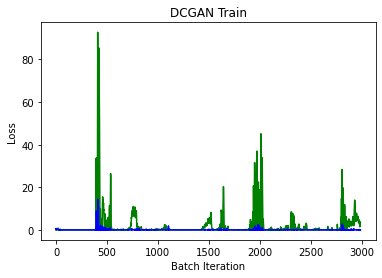

Epoch 47/100 :
     Batch 1/65 generator loss | discriminator loss : 3.95841908454895 | 0.01602010428905487 - batch took 4.461250066757202 s.
     Batch 2/65 generator loss | discriminator loss : 4.008768558502197 | 0.00256220530718565 - batch took 4.3842926025390625 s.
     Batch 3/65 generator loss | discriminator loss : 4.128861427307129 | 0.0013611845206469297 - batch took 4.268364667892456 s.
     Batch 4/65 generator loss | discriminator loss : 4.334563255310059 | 0.0019579650834202766 - batch took 4.32932710647583 s.
     Batch 5/65 generator loss | discriminator loss : 3.5549564361572266 | 0.24991588294506073 - batch took 4.425268888473511 s.
     Batch 6/65 generator loss | discriminator loss : 2.7782235145568848 | 0.0017944963183254004 - batch took 4.399285316467285 s.
     Batch 7/65 generator loss | discriminator loss : 1.130286693572998 | 0.26523852348327637 - batch took 4.288350820541382 s.
     Batch 8/65 generator loss | discriminator loss : 0.27813243865966797 | 0.0530

     Batch 63/65 generator loss | discriminator loss : 1.7242220565094613e-05 | 0.005783596076071262 - batch took 4.556187629699707 s.
     Batch 64/65 generator loss | discriminator loss : 0.00021053283126093447 | 0.01062405202537775 - batch took 4.359308242797852 s.
     Batch 65/65 generator loss | discriminator loss : 0.00021163334895391017 | 0.005891656503081322 - batch took 1.2212469577789307 s.


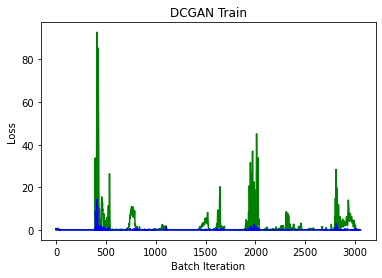

Epoch 48/100 :
     Batch 1/65 generator loss | discriminator loss : 9.212753502652049e-05 | 0.0030522122979164124 - batch took 4.365995645523071 s.
     Batch 2/65 generator loss | discriminator loss : 0.0002288436226081103 | 0.19277723133563995 - batch took 4.568179368972778 s.
     Batch 3/65 generator loss | discriminator loss : 0.0004744043981190771 | 0.0032647326588630676 - batch took 4.454250812530518 s.
     Batch 4/65 generator loss | discriminator loss : 7.174105121521279e-05 | 0.12786954641342163 - batch took 4.370302200317383 s.
     Batch 5/65 generator loss | discriminator loss : 3.2673847272235435e-06 | 0.08082360774278641 - batch took 4.301344156265259 s.
     Batch 6/65 generator loss | discriminator loss : 8.030902790778782e-06 | 0.02768079936504364 - batch took 4.4502527713775635 s.
     Batch 7/65 generator loss | discriminator loss : 7.979981546668569e-07 | 0.05499955639243126 - batch took 4.375300168991089 s.
     Batch 8/65 generator loss | discriminator loss : 2

     Batch 63/65 generator loss | discriminator loss : 0.1350094974040985 | 0.0013363789767026901 - batch took 4.357311010360718 s.
     Batch 64/65 generator loss | discriminator loss : 0.05933124199509621 | 0.0007081264047883451 - batch took 4.2673656940460205 s.
     Batch 65/65 generator loss | discriminator loss : 0.03590639680624008 | 0.09425962716341019 - batch took 1.270214557647705 s.


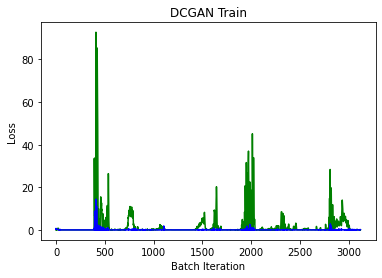

Epoch 49/100 :
     Batch 1/65 generator loss | discriminator loss : 0.021980687975883484 | 0.053344473242759705 - batch took 4.2958385944366455 s.
     Batch 2/65 generator loss | discriminator loss : 0.0019155729096382856 | 0.11512091755867004 - batch took 4.379296541213989 s.
     Batch 3/65 generator loss | discriminator loss : 0.0037745297886431217 | 0.0065607596188783646 - batch took 4.491227388381958 s.
     Batch 4/65 generator loss | discriminator loss : 0.0005088237812742591 | 0.024202629923820496 - batch took 4.456248998641968 s.
     Batch 5/65 generator loss | discriminator loss : 0.0007678247638978064 | 0.058724869042634964 - batch took 4.391288757324219 s.
     Batch 6/65 generator loss | discriminator loss : 0.020311297848820686 | 0.04531015083193779 - batch took 4.473238706588745 s.
     Batch 7/65 generator loss | discriminator loss : 0.041163377463817596 | 0.012874954380095005 - batch took 4.419271945953369 s.
     Batch 8/65 generator loss | discriminator loss : 0.0

     Batch 63/65 generator loss | discriminator loss : 0.1325044333934784 | 0.0009766648290678859 - batch took 4.290351629257202 s.
     Batch 64/65 generator loss | discriminator loss : 0.22946052253246307 | 0.010043670423328876 - batch took 4.4532506465911865 s.
     Batch 65/65 generator loss | discriminator loss : 0.17008259892463684 | 0.0003215220640413463 - batch took 1.2072546482086182 s.


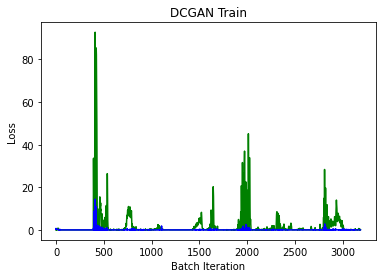

Epoch 50/100 :
     Batch 1/65 generator loss | discriminator loss : 0.03951612859964371 | 0.00029401888605207205 - batch took 4.492056369781494 s.
     Batch 2/65 generator loss | discriminator loss : 0.07082435488700867 | 0.0004089032008778304 - batch took 4.3633058071136475 s.
     Batch 3/65 generator loss | discriminator loss : 0.06020798906683922 | 0.0044983988627791405 - batch took 4.363306522369385 s.
     Batch 4/65 generator loss | discriminator loss : 0.03282136842608452 | 0.0007823348860256374 - batch took 4.399284601211548 s.
     Batch 5/65 generator loss | discriminator loss : 0.011657476425170898 | 0.033675145357847214 - batch took 4.43326210975647 s.
     Batch 6/65 generator loss | discriminator loss : 0.0327213853597641 | 0.0020350199192762375 - batch took 4.445255994796753 s.
     Batch 7/65 generator loss | discriminator loss : 0.01796419359743595 | 0.0019419325981289148 - batch took 4.347316741943359 s.
     Batch 8/65 generator loss | discriminator loss : 0.04568

     Batch 62/65 generator loss | discriminator loss : 0.0036298446357250214 | 0.000433587993029505 - batch took 4.379296541213989 s.
     Batch 63/65 generator loss | discriminator loss : 0.02017786167562008 | 0.0005256464937701821 - batch took 4.3643059730529785 s.
     Batch 64/65 generator loss | discriminator loss : 0.12527234852313995 | 0.00017425567784812301 - batch took 4.262368440628052 s.
     Batch 65/65 generator loss | discriminator loss : 0.001770293340086937 | 0.00037632923340424895 - batch took 1.212251901626587 s.


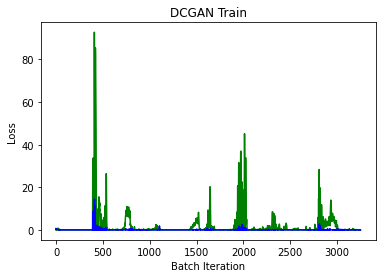

Epoch 51/100 :
     Batch 1/65 generator loss | discriminator loss : 0.026362627744674683 | 8.697854354977608e-05 - batch took 4.252954483032227 s.
     Batch 2/65 generator loss | discriminator loss : 0.011135506443679333 | 0.00013712659711018205 - batch took 4.4212706089019775 s.
     Batch 3/65 generator loss | discriminator loss : 0.008720308542251587 | 7.701662252657115e-05 - batch took 4.36030912399292 s.
     Batch 4/65 generator loss | discriminator loss : 0.010115016251802444 | 5.359470014809631e-05 - batch took 4.392288684844971 s.
     Batch 5/65 generator loss | discriminator loss : 0.007556311786174774 | 8.922687993617728e-05 - batch took 4.290351867675781 s.
     Batch 6/65 generator loss | discriminator loss : 0.031047096475958824 | 9.196094470098615e-05 - batch took 4.467242956161499 s.
     Batch 7/65 generator loss | discriminator loss : 0.006434768438339233 | 0.00016225542640313506 - batch took 4.539197683334351 s.
     Batch 8/65 generator loss | discriminator loss 

     Batch 62/65 generator loss | discriminator loss : 0.021564001217484474 | 0.0002811610756907612 - batch took 4.4842329025268555 s.
     Batch 63/65 generator loss | discriminator loss : 0.007024361286312342 | 0.0013456743909046054 - batch took 4.371302127838135 s.
     Batch 64/65 generator loss | discriminator loss : 0.014738921076059341 | 0.0003521231119520962 - batch took 4.379295825958252 s.
     Batch 65/65 generator loss | discriminator loss : 0.010937207378447056 | 2.007272451010067e-05 - batch took 1.20725417137146 s.


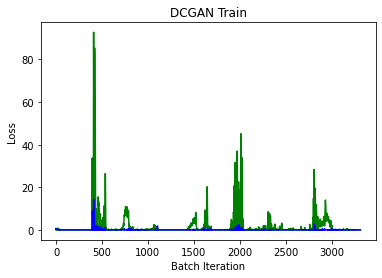

Epoch 52/100 :
     Batch 1/65 generator loss | discriminator loss : 0.034270551055669785 | 0.0004902846994809806 - batch took 4.426273345947266 s.
     Batch 2/65 generator loss | discriminator loss : 0.02232534810900688 | 0.00010471499990671873 - batch took 4.332324981689453 s.
     Batch 3/65 generator loss | discriminator loss : 0.07604898512363434 | 0.00015680711658205837 - batch took 4.415273904800415 s.
     Batch 4/65 generator loss | discriminator loss : 0.021931059658527374 | 0.0003560151671990752 - batch took 4.329329013824463 s.
     Batch 5/65 generator loss | discriminator loss : 0.03492496907711029 | 0.00018150245887227356 - batch took 4.298346281051636 s.
     Batch 6/65 generator loss | discriminator loss : 0.04167824238538742 | 0.0003802048449870199 - batch took 4.385292291641235 s.
     Batch 7/65 generator loss | discriminator loss : 0.047806818038225174 | 0.008978260681033134 - batch took 4.772053241729736 s.
     Batch 8/65 generator loss | discriminator loss : 0.

     Batch 64/65 generator loss | discriminator loss : 8.366582870483398 | 0.006425909232348204 - batch took 4.367305278778076 s.
     Batch 65/65 generator loss | discriminator loss : 9.761919021606445 | 0.00783158652484417 - batch took 1.1782724857330322 s.


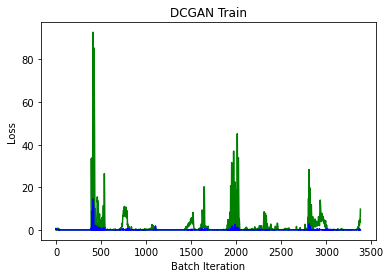

Epoch 53/100 :
     Batch 1/65 generator loss | discriminator loss : 9.95998764038086 | 0.001902942662127316 - batch took 4.482230186462402 s.
     Batch 2/65 generator loss | discriminator loss : 8.126428604125977 | 0.2498643696308136 - batch took 4.322331428527832 s.
     Batch 3/65 generator loss | discriminator loss : 4.788668155670166 | 0.2865768373012543 - batch took 4.3003456592559814 s.
     Batch 4/65 generator loss | discriminator loss : 3.658020496368408 | 0.021523606032133102 - batch took 4.470240116119385 s.
     Batch 5/65 generator loss | discriminator loss : 9.424568176269531 | 0.41540825366973877 - batch took 4.364305019378662 s.
     Batch 6/65 generator loss | discriminator loss : 13.490629196166992 | 0.0007237077224999666 - batch took 4.3003458976745605 s.
     Batch 7/65 generator loss | discriminator loss : 16.86861801147461 | 4.795245695277117e-05 - batch took 4.325329542160034 s.
     Batch 8/65 generator loss | discriminator loss : 20.432861328125 | 0.001970508

     Batch 63/65 generator loss | discriminator loss : 8.580977919336874e-06 | 1.4917936823621858e-06 - batch took 4.409278631210327 s.
     Batch 64/65 generator loss | discriminator loss : 6.975299129408086e-06 | 4.637618076230865e-07 - batch took 4.451250314712524 s.
     Batch 65/65 generator loss | discriminator loss : 5.095494088891428e-06 | 1.2274368543785386e-07 - batch took 1.1942639350891113 s.


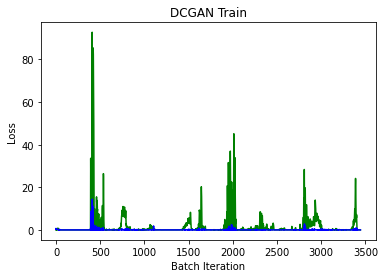

Epoch 54/100 :
     Batch 1/65 generator loss | discriminator loss : 3.999417913291836e-06 | 0.0005832584574818611 - batch took 4.486796617507935 s.
     Batch 2/65 generator loss | discriminator loss : 3.3955097933358047e-06 | 9.058016985363793e-06 - batch took 4.375299453735352 s.
     Batch 3/65 generator loss | discriminator loss : 3.2110897336679045e-06 | 5.669288839271758e-06 - batch took 4.434262990951538 s.
     Batch 4/65 generator loss | discriminator loss : 2.9181255740695633e-06 | 0.07582762092351913 - batch took 4.444256067276001 s.
     Batch 5/65 generator loss | discriminator loss : 1.5464424905076157e-06 | 7.579138582514133e-06 - batch took 4.6501305103302 s.
     Batch 6/65 generator loss | discriminator loss : 1.0479340062374831e-06 | 2.8863249099231325e-05 - batch took 4.435261249542236 s.
     Batch 7/65 generator loss | discriminator loss : 7.90404669714917e-07 | 4.030500349472277e-05 - batch took 4.308340311050415 s.
     Batch 8/65 generator loss | discriminator

     Batch 62/65 generator loss | discriminator loss : 0.025775713846087456 | 2.4571419999119826e-05 - batch took 4.4002368450164795 s.
     Batch 63/65 generator loss | discriminator loss : 0.05132409930229187 | 3.42570201610215e-05 - batch took 4.565181493759155 s.
     Batch 64/65 generator loss | discriminator loss : 0.031436704099178314 | 8.402946696151048e-05 - batch took 4.314336061477661 s.
     Batch 65/65 generator loss | discriminator loss : 0.038487501442432404 | 1.2242127922945656e-05 - batch took 1.2072563171386719 s.


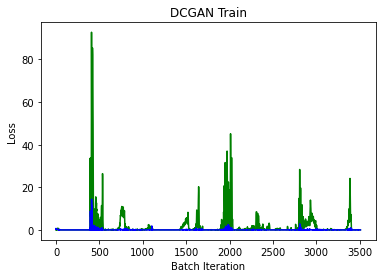

Epoch 55/100 :
     Batch 1/65 generator loss | discriminator loss : 0.022199707105755806 | 0.00013129605213180184 - batch took 4.278362512588501 s.
     Batch 2/65 generator loss | discriminator loss : 0.02462480403482914 | 9.695323387859389e-05 - batch took 4.420270919799805 s.
     Batch 3/65 generator loss | discriminator loss : 0.021396497264504433 | 0.0020011691376566887 - batch took 4.400283098220825 s.
     Batch 4/65 generator loss | discriminator loss : 0.017480378970503807 | 0.00024117040447890759 - batch took 4.413283586502075 s.
     Batch 5/65 generator loss | discriminator loss : 0.022431623190641403 | 0.0001490122522227466 - batch took 4.402281761169434 s.
     Batch 6/65 generator loss | discriminator loss : 0.027229486033320427 | 0.0002704394864849746 - batch took 4.488229274749756 s.
     Batch 7/65 generator loss | discriminator loss : 0.014329532161355019 | 0.0002807696000672877 - batch took 4.427266359329224 s.
     Batch 8/65 generator loss | discriminator loss :

     Batch 64/65 generator loss | discriminator loss : 7.66682243347168 | 0.038327980786561966 - batch took 4.405281066894531 s.
     Batch 65/65 generator loss | discriminator loss : 7.760865688323975 | 0.006995851173996925 - batch took 1.19026517868042 s.


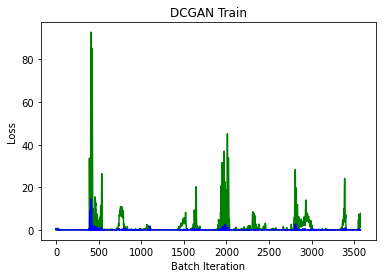

Epoch 56/100 :
     Batch 1/65 generator loss | discriminator loss : 6.836651802062988 | 0.05949868634343147 - batch took 4.403276443481445 s.
     Batch 2/65 generator loss | discriminator loss : 6.053502559661865 | 0.0003274065675213933 - batch took 4.345318078994751 s.
     Batch 3/65 generator loss | discriminator loss : 5.350066661834717 | 0.0007092703599482775 - batch took 4.353312253952026 s.
     Batch 4/65 generator loss | discriminator loss : 4.913277626037598 | 0.0016325435135513544 - batch took 4.478236198425293 s.
     Batch 5/65 generator loss | discriminator loss : 3.8600053787231445 | 0.062294721603393555 - batch took 4.421268939971924 s.
     Batch 6/65 generator loss | discriminator loss : 3.07336688041687 | 0.009980655275285244 - batch took 4.395286798477173 s.
     Batch 7/65 generator loss | discriminator loss : 2.532835006713867 | 0.012828538194298744 - batch took 4.269365549087524 s.
     Batch 8/65 generator loss | discriminator loss : 2.6207363605499268 | 0.023

     Batch 64/65 generator loss | discriminator loss : 6.805665016174316 | 0.0008243244374170899 - batch took 4.472239255905151 s.
     Batch 65/65 generator loss | discriminator loss : 6.730024337768555 | 0.0002042227133642882 - batch took 1.1822702884674072 s.


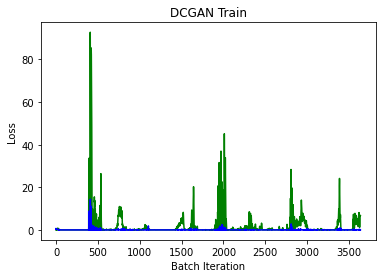

Epoch 57/100 :
     Batch 1/65 generator loss | discriminator loss : 6.8921051025390625 | 0.00044603500282391906 - batch took 4.417914152145386 s.
     Batch 2/65 generator loss | discriminator loss : 6.380573272705078 | 0.036472421139478683 - batch took 4.3503148555755615 s.
     Batch 3/65 generator loss | discriminator loss : 5.850614547729492 | 0.0005649777594953775 - batch took 4.295348405838013 s.
     Batch 4/65 generator loss | discriminator loss : 5.324498176574707 | 0.0008498263778164983 - batch took 4.3513147830963135 s.
     Batch 5/65 generator loss | discriminator loss : 4.97284460067749 | 0.0013826657086610794 - batch took 4.432264804840088 s.
     Batch 6/65 generator loss | discriminator loss : 4.090224742889404 | 0.03842412680387497 - batch took 4.34231972694397 s.
     Batch 7/65 generator loss | discriminator loss : 3.5576162338256836 | 0.006801343522965908 - batch took 4.351313352584839 s.
     Batch 8/65 generator loss | discriminator loss : 3.1895623207092285 | 0

     Batch 64/65 generator loss | discriminator loss : 0.3628733158111572 | 0.5642451643943787 - batch took 4.3253302574157715 s.
     Batch 65/65 generator loss | discriminator loss : 0.12110402435064316 | 0.0006480691954493523 - batch took 1.2092533111572266 s.


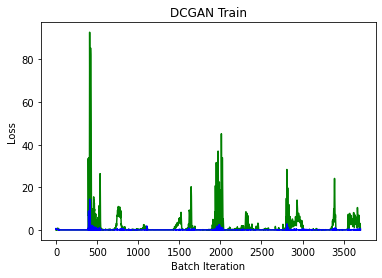

Epoch 58/100 :
     Batch 1/65 generator loss | discriminator loss : 0.01829051598906517 | 0.011463171802461147 - batch took 4.293351888656616 s.
     Batch 2/65 generator loss | discriminator loss : 0.07819537073373795 | 0.06260886788368225 - batch took 4.483232498168945 s.
     Batch 3/65 generator loss | discriminator loss : 0.007794748991727829 | 0.04704929143190384 - batch took 4.454251527786255 s.
     Batch 4/65 generator loss | discriminator loss : 0.19588778913021088 | 0.19355596601963043 - batch took 4.534198760986328 s.
     Batch 5/65 generator loss | discriminator loss : 0.3298136591911316 | 0.008314031176269054 - batch took 4.359309196472168 s.
     Batch 6/65 generator loss | discriminator loss : 0.9296396970748901 | 0.008140888065099716 - batch took 4.415274381637573 s.
     Batch 7/65 generator loss | discriminator loss : 1.0714352130889893 | 0.04145029932260513 - batch took 4.375298976898193 s.
     Batch 8/65 generator loss | discriminator loss : 1.9730305671691895 |

     Batch 63/65 generator loss | discriminator loss : 0.31170445680618286 | 0.00015166084631346166 - batch took 4.431265115737915 s.
     Batch 64/65 generator loss | discriminator loss : 0.19879312813282013 | 0.006035360507667065 - batch took 4.398285388946533 s.
     Batch 65/65 generator loss | discriminator loss : 0.6361775398254395 | 0.000791506317909807 - batch took 1.2052562236785889 s.


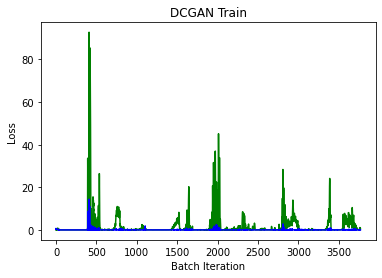

Epoch 59/100 :
     Batch 1/65 generator loss | discriminator loss : 0.25803664326667786 | 0.0008454343769699335 - batch took 4.3101630210876465 s.
     Batch 2/65 generator loss | discriminator loss : 0.16132619976997375 | 0.0008045891881920397 - batch took 4.301345586776733 s.
     Batch 3/65 generator loss | discriminator loss : 0.2063000500202179 | 0.002957127522677183 - batch took 4.421269178390503 s.
     Batch 4/65 generator loss | discriminator loss : 0.14770469069480896 | 0.0025780214928090572 - batch took 4.378297328948975 s.
     Batch 5/65 generator loss | discriminator loss : 0.11964257806539536 | 0.0006232959567569196 - batch took 4.3393213748931885 s.
     Batch 6/65 generator loss | discriminator loss : 0.08620657026767731 | 0.015808867290616035 - batch took 4.314335823059082 s.
     Batch 7/65 generator loss | discriminator loss : 0.15744931995868683 | 0.0006782782729715109 - batch took 4.495225191116333 s.
     Batch 8/65 generator loss | discriminator loss : 0.332362

     Batch 64/65 generator loss | discriminator loss : 1.120470643043518 | 0.013969624415040016 - batch took 4.365304470062256 s.
     Batch 65/65 generator loss | discriminator loss : 1.8622015714645386 | 0.03825505077838898 - batch took 1.2232458591461182 s.


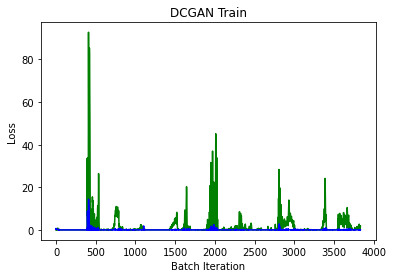

Epoch 60/100 :
     Batch 1/65 generator loss | discriminator loss : 2.967895984649658 | 0.0269185658544302 - batch took 4.3273255825042725 s.
     Batch 2/65 generator loss | discriminator loss : 3.5540049076080322 | 0.006861760746687651 - batch took 4.466242790222168 s.
     Batch 3/65 generator loss | discriminator loss : 4.101325511932373 | 0.06765172630548477 - batch took 4.434262275695801 s.
     Batch 4/65 generator loss | discriminator loss : 4.590699195861816 | 0.00915114488452673 - batch took 4.43526291847229 s.
     Batch 5/65 generator loss | discriminator loss : 4.104796409606934 | 0.00022784771863371134 - batch took 4.2913501262664795 s.
     Batch 6/65 generator loss | discriminator loss : 5.781520843505859 | 0.007187817245721817 - batch took 4.441258192062378 s.
     Batch 7/65 generator loss | discriminator loss : 4.653653621673584 | 0.002007696544751525 - batch took 4.410277366638184 s.
     Batch 8/65 generator loss | discriminator loss : 4.947331428527832 | 0.000319

     Batch 63/65 generator loss | discriminator loss : 0.006011512596160173 | 0.004371443763375282 - batch took 4.470240354537964 s.
     Batch 64/65 generator loss | discriminator loss : 0.03423595428466797 | 0.003506644628942013 - batch took 4.435262441635132 s.
     Batch 65/65 generator loss | discriminator loss : 0.02222505770623684 | 9.064649930223823e-05 - batch took 1.1942620277404785 s.


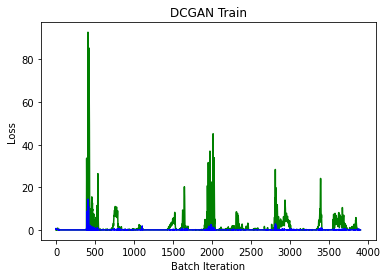

Epoch 61/100 :
     Batch 1/65 generator loss | discriminator loss : 0.04884202405810356 | 0.0004803717019967735 - batch took 4.4672324657440186 s.
     Batch 2/65 generator loss | discriminator loss : 0.027430646121501923 | 0.0004599201784003526 - batch took 4.36930251121521 s.
     Batch 3/65 generator loss | discriminator loss : 0.0586942620575428 | 7.896492024883628e-05 - batch took 4.370302438735962 s.
     Batch 4/65 generator loss | discriminator loss : 0.006184367462992668 | 0.0009574844734743237 - batch took 4.406279563903809 s.
     Batch 5/65 generator loss | discriminator loss : 0.007024715188890696 | 0.0002455129870213568 - batch took 4.52220892906189 s.
     Batch 6/65 generator loss | discriminator loss : 0.03226149082183838 | 0.00045516202226281166 - batch took 4.40228271484375 s.
     Batch 7/65 generator loss | discriminator loss : 0.01773838885128498 | 0.0014483053237199783 - batch took 4.3852925300598145 s.
     Batch 8/65 generator loss | discriminator loss : 0.034

     Batch 62/65 generator loss | discriminator loss : 3.845158062176779e-05 | 0.2887859046459198 - batch took 4.482231855392456 s.
     Batch 63/65 generator loss | discriminator loss : 8.035006612772122e-05 | 0.007581510581076145 - batch took 4.378298044204712 s.
     Batch 64/65 generator loss | discriminator loss : 0.00015747618454042822 | 0.001502159284427762 - batch took 4.348315715789795 s.
     Batch 65/65 generator loss | discriminator loss : 2.1882385681237793e-06 | 0.01639573834836483 - batch took 1.245232343673706 s.


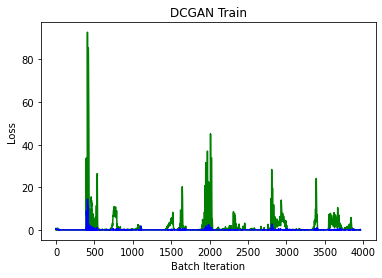

Epoch 62/100 :
     Batch 1/65 generator loss | discriminator loss : 0.001003580167889595 | 0.02437758632004261 - batch took 4.265363931655884 s.
     Batch 2/65 generator loss | discriminator loss : 0.0005690854741260409 | 0.057341139763593674 - batch took 4.484232187271118 s.
     Batch 3/65 generator loss | discriminator loss : 0.0016678678803145885 | 0.038565125316381454 - batch took 4.434262752532959 s.
     Batch 4/65 generator loss | discriminator loss : 0.11912326514720917 | 0.00125570734962821 - batch took 4.3992838859558105 s.
     Batch 5/65 generator loss | discriminator loss : 0.18733033537864685 | 0.00018138217274099588 - batch took 4.340320587158203 s.
     Batch 6/65 generator loss | discriminator loss : 1.2232192754745483 | 0.00012820365373045206 - batch took 4.45425009727478 s.
     Batch 7/65 generator loss | discriminator loss : 1.6262489557266235 | 0.00024214788572862744 - batch took 4.445256233215332 s.
     Batch 8/65 generator loss | discriminator loss : 0.94246

     Batch 62/65 generator loss | discriminator loss : 9.458251588512212e-05 | 1.5785652067279443e-05 - batch took 4.440258741378784 s.
     Batch 63/65 generator loss | discriminator loss : 0.0008224850753322244 | 1.1191192243131809e-05 - batch took 4.351313591003418 s.
     Batch 64/65 generator loss | discriminator loss : 0.0004048508417326957 | 0.21017247438430786 - batch took 4.451251983642578 s.
     Batch 65/65 generator loss | discriminator loss : 0.00014916638610884547 | 3.3919494768497316e-08 - batch took 1.1752734184265137 s.


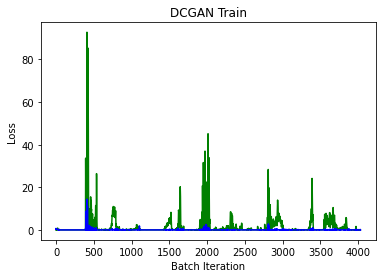

Epoch 63/100 :
     Batch 1/65 generator loss | discriminator loss : 4.670861017075367e-05 | 2.248034070362337e-05 - batch took 4.468236207962036 s.
     Batch 2/65 generator loss | discriminator loss : 1.1544431117727072e-06 | 3.1232775654643774e-05 - batch took 4.372300863265991 s.
     Batch 3/65 generator loss | discriminator loss : 1.0289842975907959e-05 | 0.00906360987573862 - batch took 4.354310989379883 s.
     Batch 4/65 generator loss | discriminator loss : 8.398484169447329e-06 | 0.0001630082115298137 - batch took 4.426269054412842 s.
     Batch 5/65 generator loss | discriminator loss : 5.787424015579745e-06 | 0.0012732777977362275 - batch took 4.46424412727356 s.
     Batch 6/65 generator loss | discriminator loss : 2.4331598069693428e-06 | 0.0008345266105607152 - batch took 4.419272184371948 s.
     Batch 7/65 generator loss | discriminator loss : 4.561632522381842e-05 | 0.0007868814282119274 - batch took 4.396286249160767 s.
     Batch 8/65 generator loss | discriminator

     Batch 62/65 generator loss | discriminator loss : 0.10873781144618988 | 0.0001589061284903437 - batch took 4.45525050163269 s.
     Batch 63/65 generator loss | discriminator loss : 0.25036272406578064 | 7.648823520867154e-05 - batch took 4.41627311706543 s.
     Batch 64/65 generator loss | discriminator loss : 0.34152042865753174 | 0.0003741044201888144 - batch took 4.3812949657440186 s.
     Batch 65/65 generator loss | discriminator loss : 0.5361371040344238 | 6.0481703258119524e-05 - batch took 1.266218662261963 s.


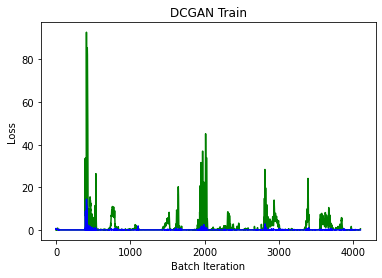

Epoch 64/100 :
     Batch 1/65 generator loss | discriminator loss : 0.1365179568529129 | 0.00015474796236958355 - batch took 4.265367031097412 s.
     Batch 2/65 generator loss | discriminator loss : 0.05544496327638626 | 0.00034431484527885914 - batch took 4.442257642745972 s.
     Batch 3/65 generator loss | discriminator loss : 0.019593805074691772 | 0.00020232753013260663 - batch took 4.443256139755249 s.
     Batch 4/65 generator loss | discriminator loss : 0.004448512103408575 | 0.0007878554752096534 - batch took 4.400284290313721 s.
     Batch 5/65 generator loss | discriminator loss : 0.007839017547667027 | 0.009898020885884762 - batch took 4.3133368492126465 s.
     Batch 6/65 generator loss | discriminator loss : 0.016602832823991776 | 0.0012458795681595802 - batch took 4.446255683898926 s.
     Batch 7/65 generator loss | discriminator loss : 0.019500909373164177 | 0.001796243479475379 - batch took 4.408278465270996 s.
     Batch 8/65 generator loss | discriminator loss : 0

     Batch 63/65 generator loss | discriminator loss : 0.00569714792072773 | 0.027501650154590607 - batch took 4.3852925300598145 s.
     Batch 64/65 generator loss | discriminator loss : 0.030487244948744774 | 0.01813405379652977 - batch took 4.373300075531006 s.
     Batch 65/65 generator loss | discriminator loss : 0.05367220193147659 | 0.0040454869158566 - batch took 1.2282423973083496 s.


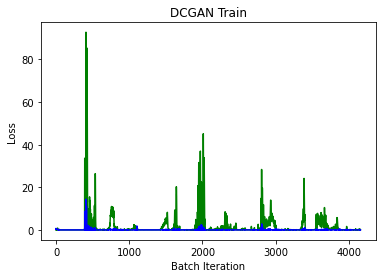

Epoch 65/100 :
     Batch 1/65 generator loss | discriminator loss : 0.45653456449508667 | 0.0058519961312413216 - batch took 4.3599042892456055 s.
     Batch 2/65 generator loss | discriminator loss : 0.6538984775543213 | 0.009884550236165524 - batch took 4.344318866729736 s.
     Batch 3/65 generator loss | discriminator loss : 1.0158088207244873 | 0.001146383467130363 - batch took 4.476235866546631 s.
     Batch 4/65 generator loss | discriminator loss : 0.6479073166847229 | 0.013585914857685566 - batch took 4.4112770557403564 s.
     Batch 5/65 generator loss | discriminator loss : 0.3452420234680176 | 0.000969652843195945 - batch took 4.398284435272217 s.
     Batch 6/65 generator loss | discriminator loss : 0.23944786190986633 | 0.011444825679063797 - batch took 4.352313756942749 s.
     Batch 7/65 generator loss | discriminator loss : 0.13003593683242798 | 0.01024513877928257 - batch took 4.439258098602295 s.
     Batch 8/65 generator loss | discriminator loss : 0.09545923769474

     Batch 64/65 generator loss | discriminator loss : 0.13800454139709473 | 0.0002919754770118743 - batch took 4.414275646209717 s.
     Batch 65/65 generator loss | discriminator loss : 0.0007974064792506397 | 1.0075761079788208 - batch took 1.18226957321167 s.


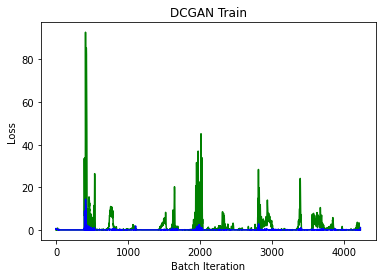

Epoch 66/100 :
     Batch 1/65 generator loss | discriminator loss : 0.00023115311341825873 | 0.10352043807506561 - batch took 4.408279180526733 s.
     Batch 2/65 generator loss | discriminator loss : 6.278799057006836 | 0.4882015883922577 - batch took 4.389289855957031 s.
     Batch 3/65 generator loss | discriminator loss : 20.060976028442383 | 4.828876262763515e-05 - batch took 4.345317840576172 s.
     Batch 4/65 generator loss | discriminator loss : 28.766443252563477 | 0.2960805594921112 - batch took 4.449253082275391 s.
     Batch 5/65 generator loss | discriminator loss : 35.45761489868164 | 0.032682232558727264 - batch took 4.415273904800415 s.
     Batch 6/65 generator loss | discriminator loss : 34.549171447753906 | 0.24595007300376892 - batch took 4.387292146682739 s.
     Batch 7/65 generator loss | discriminator loss : 31.748035430908203 | 0.36044320464134216 - batch took 4.574176549911499 s.
     Batch 8/65 generator loss | discriminator loss : 24.846168518066406 | 0.08

     Batch 63/65 generator loss | discriminator loss : 0.0011386452242732048 | 0.0001330796512775123 - batch took 4.355311870574951 s.
     Batch 64/65 generator loss | discriminator loss : 0.0015179519541561604 | 0.000269915908575058 - batch took 4.4642438888549805 s.
     Batch 65/65 generator loss | discriminator loss : 0.002778018359094858 | 0.00013274354569148272 - batch took 1.193263053894043 s.


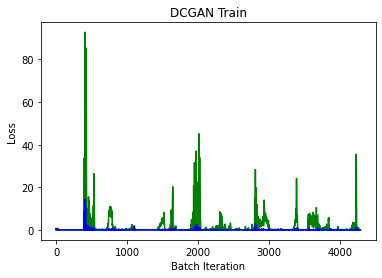

Epoch 67/100 :
     Batch 1/65 generator loss | discriminator loss : 0.0021341489627957344 | 0.00027963833417743444 - batch took 4.449510812759399 s.
     Batch 2/65 generator loss | discriminator loss : 0.0025425157509744167 | 0.00030619854805991054 - batch took 4.507216453552246 s.
     Batch 3/65 generator loss | discriminator loss : 0.0058007254265248775 | 0.0026585718151181936 - batch took 4.359309434890747 s.
     Batch 4/65 generator loss | discriminator loss : 0.003834497882053256 | 8.830111619317904e-05 - batch took 4.3932883739471436 s.
     Batch 5/65 generator loss | discriminator loss : 0.0033254961017519236 | 0.0002218591544078663 - batch took 4.5252063274383545 s.
     Batch 6/65 generator loss | discriminator loss : 0.002458497416228056 | 0.001060358015820384 - batch took 4.42227029800415 s.
     Batch 7/65 generator loss | discriminator loss : 0.006383842788636684 | 0.0002864926937036216 - batch took 4.3673036098480225 s.
     Batch 8/65 generator loss | discriminator 

     Batch 63/65 generator loss | discriminator loss : 0.19019508361816406 | 6.813259096816182e-05 - batch took 4.371302127838135 s.
     Batch 64/65 generator loss | discriminator loss : 0.12066856026649475 | 6.0131234931759536e-05 - batch took 4.453250169754028 s.
     Batch 65/65 generator loss | discriminator loss : 0.09245559573173523 | 0.00048522360157221556 - batch took 1.2612223625183105 s.


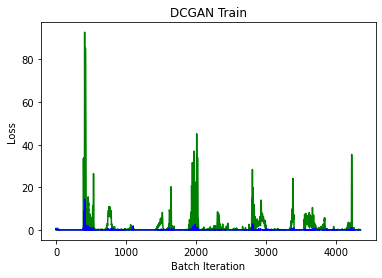

Epoch 68/100 :
     Batch 1/65 generator loss | discriminator loss : 0.06138075515627861 | 0.00030349413282237947 - batch took 4.3425822257995605 s.
     Batch 2/65 generator loss | discriminator loss : 0.06092474237084389 | 6.947985821170732e-05 - batch took 4.464244604110718 s.
     Batch 3/65 generator loss | discriminator loss : 0.06185898557305336 | 0.0004080991493538022 - batch took 4.452250719070435 s.
     Batch 4/65 generator loss | discriminator loss : 0.040498215705156326 | 0.00010392506374046206 - batch took 4.415274620056152 s.
     Batch 5/65 generator loss | discriminator loss : 0.03716300427913666 | 0.0004578718217089772 - batch took 4.344318151473999 s.
     Batch 6/65 generator loss | discriminator loss : 0.04287205636501312 | 0.00010568947618594393 - batch took 4.453250169754028 s.
     Batch 7/65 generator loss | discriminator loss : 0.027862027287483215 | 0.0005670124664902687 - batch took 4.445255994796753 s.
     Batch 8/65 generator loss | discriminator loss : 0

     Batch 63/65 generator loss | discriminator loss : 0.10412048548460007 | 0.0005798274651169777 - batch took 4.668119192123413 s.
     Batch 64/65 generator loss | discriminator loss : 0.09080378711223602 | 0.0004764879122376442 - batch took 4.408277988433838 s.
     Batch 65/65 generator loss | discriminator loss : 0.12322796881198883 | 0.000344362371833995 - batch took 1.1992599964141846 s.


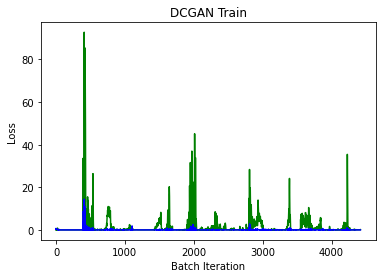

Epoch 69/100 :
     Batch 1/65 generator loss | discriminator loss : 0.10000525414943695 | 0.0005644041229970753 - batch took 4.479682922363281 s.
     Batch 2/65 generator loss | discriminator loss : 0.09449771791696548 | 0.003019329160451889 - batch took 4.417273998260498 s.
     Batch 3/65 generator loss | discriminator loss : 0.08615608513355255 | 0.005646824836730957 - batch took 4.324329137802124 s.
     Batch 4/65 generator loss | discriminator loss : 0.056695856153964996 | 0.0007458700565621257 - batch took 4.464244604110718 s.
     Batch 5/65 generator loss | discriminator loss : 0.05247872322797775 | 0.0013805306516587734 - batch took 4.420271635055542 s.
     Batch 6/65 generator loss | discriminator loss : 0.03678794577717781 | 0.0008956102537922561 - batch took 4.442257642745972 s.
     Batch 7/65 generator loss | discriminator loss : 0.027842693030834198 | 0.00075133191421628 - batch took 4.356310129165649 s.
     Batch 8/65 generator loss | discriminator loss : 0.0446256

     Batch 63/65 generator loss | discriminator loss : 0.3067641258239746 | 0.0014601642033085227 - batch took 4.433264255523682 s.
     Batch 64/65 generator loss | discriminator loss : 0.14901205897331238 | 1.0670558367564809e-05 - batch took 4.38129448890686 s.
     Batch 65/65 generator loss | discriminator loss : 0.056209746748209 | 3.8199290429474786e-05 - batch took 1.2392351627349854 s.


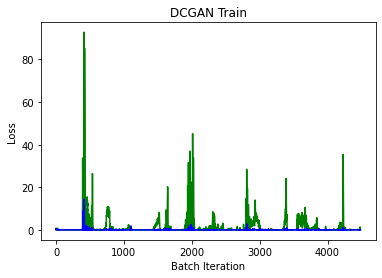

Epoch 70/100 :
     Batch 1/65 generator loss | discriminator loss : 0.029158268123865128 | 0.005097582004964352 - batch took 4.282355546951294 s.
     Batch 2/65 generator loss | discriminator loss : 0.014502634294331074 | 0.0001662688737269491 - batch took 4.4872307777404785 s.
     Batch 3/65 generator loss | discriminator loss : 0.002872569253668189 | 0.023292699828743935 - batch took 4.4022815227508545 s.
     Batch 4/65 generator loss | discriminator loss : 0.0009453814709559083 | 0.002696846378967166 - batch took 4.586168527603149 s.
     Batch 5/65 generator loss | discriminator loss : 0.000391499197576195 | 0.008609404787421227 - batch took 4.355312824249268 s.
     Batch 6/65 generator loss | discriminator loss : 0.0003661836381070316 | 0.007830005139112473 - batch took 4.467240810394287 s.
     Batch 7/65 generator loss | discriminator loss : 0.0010504822712391615 | 0.015501804649829865 - batch took 4.539198637008667 s.
     Batch 8/65 generator loss | discriminator loss : 0

     Batch 63/65 generator loss | discriminator loss : 0.040700942277908325 | 0.07139609009027481 - batch took 4.446254014968872 s.
     Batch 64/65 generator loss | discriminator loss : 0.011365627869963646 | 0.007917225360870361 - batch took 4.380297422409058 s.
     Batch 65/65 generator loss | discriminator loss : 0.003127986565232277 | 0.0016372150275856256 - batch took 1.217247724533081 s.


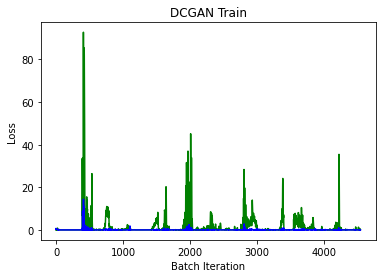

Epoch 71/100 :
     Batch 1/65 generator loss | discriminator loss : 0.0012624886585399508 | 0.004832607693970203 - batch took 4.383336782455444 s.
     Batch 2/65 generator loss | discriminator loss : 0.0010690537746995687 | 0.005682462360709906 - batch took 4.350314140319824 s.
     Batch 3/65 generator loss | discriminator loss : 0.0021929582580924034 | 0.005826721899211407 - batch took 4.5012218952178955 s.
     Batch 4/65 generator loss | discriminator loss : 0.013657085597515106 | 0.008031681180000305 - batch took 4.452252388000488 s.
     Batch 5/65 generator loss | discriminator loss : 0.11585073173046112 | 0.004708148073405027 - batch took 4.364305734634399 s.
     Batch 6/65 generator loss | discriminator loss : 0.4243897795677185 | 0.00016893386782612652 - batch took 4.355311393737793 s.
     Batch 7/65 generator loss | discriminator loss : 0.894076943397522 | 2.3006748961051926e-05 - batch took 4.458247184753418 s.
     Batch 8/65 generator loss | discriminator loss : 1.320

     Batch 63/65 generator loss | discriminator loss : 0.0374029278755188 | 0.0023919795639812946 - batch took 4.4682416915893555 s.
     Batch 64/65 generator loss | discriminator loss : 0.050598613917827606 | 0.0015501612797379494 - batch took 4.509216785430908 s.
     Batch 65/65 generator loss | discriminator loss : 0.059444084763526917 | 0.0010912336874753237 - batch took 1.1982591152191162 s.


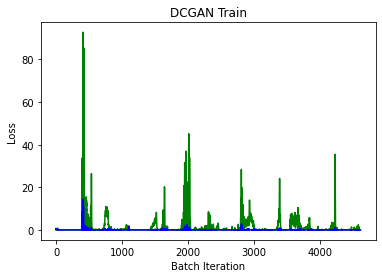

Epoch 72/100 :
     Batch 1/65 generator loss | discriminator loss : 0.11269690096378326 | 0.001274112262763083 - batch took 4.403479337692261 s.
     Batch 2/65 generator loss | discriminator loss : 0.09713807702064514 | 0.006532093044370413 - batch took 4.393287897109985 s.
     Batch 3/65 generator loss | discriminator loss : 0.09533646702766418 | 0.0009848587214946747 - batch took 4.347315788269043 s.
     Batch 4/65 generator loss | discriminator loss : 0.09246601909399033 | 0.0011900567915290594 - batch took 4.495225429534912 s.
     Batch 5/65 generator loss | discriminator loss : 0.15223288536071777 | 0.0012419285485520959 - batch took 4.400283575057983 s.
     Batch 6/65 generator loss | discriminator loss : 0.18088242411613464 | 0.0011576104443520308 - batch took 4.3772971630096436 s.
     Batch 7/65 generator loss | discriminator loss : 0.19396713376045227 | 0.00121922860853374 - batch took 4.381295680999756 s.
     Batch 8/65 generator loss | discriminator loss : 0.23101292

     Batch 64/65 generator loss | discriminator loss : 6.528546333312988 | 0.1846691370010376 - batch took 4.476238489151001 s.
     Batch 65/65 generator loss | discriminator loss : 5.985415935516357 | 9.214569581672549e-05 - batch took 1.1892657279968262 s.


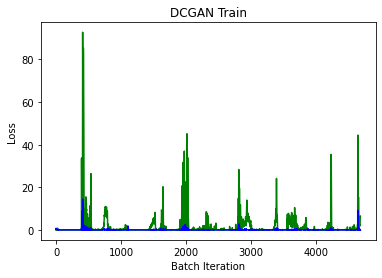

Epoch 73/100 :
     Batch 1/65 generator loss | discriminator loss : 5.759778022766113 | 0.0022665299475193024 - batch took 4.472203493118286 s.
     Batch 2/65 generator loss | discriminator loss : 4.493609428405762 | 0.1180492416024208 - batch took 4.388291358947754 s.
     Batch 3/65 generator loss | discriminator loss : 1.8129396438598633 | 0.26632341742515564 - batch took 4.381295442581177 s.
     Batch 4/65 generator loss | discriminator loss : 0.7383037805557251 | 0.09371243417263031 - batch took 4.463245153427124 s.
     Batch 5/65 generator loss | discriminator loss : 1.478962779045105 | 0.13637539744377136 - batch took 4.492225885391235 s.
     Batch 6/65 generator loss | discriminator loss : 3.4243273735046387 | 0.029429595917463303 - batch took 4.412276983261108 s.
     Batch 7/65 generator loss | discriminator loss : 3.9992551803588867 | 0.06552297621965408 - batch took 4.375298738479614 s.
     Batch 8/65 generator loss | discriminator loss : 4.070097923278809 | 0.0013064

     Batch 64/65 generator loss | discriminator loss : 5.080710411071777 | 0.16508743166923523 - batch took 4.386292219161987 s.
     Batch 65/65 generator loss | discriminator loss : 7.165522575378418 | 0.41308504343032837 - batch took 1.220247507095337 s.


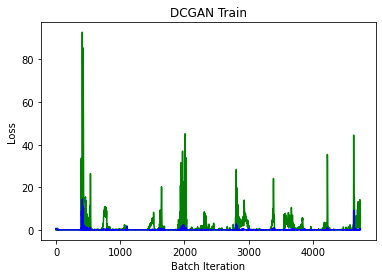

Epoch 74/100 :
     Batch 1/65 generator loss | discriminator loss : 9.452272415161133 | 0.0033570784144103527 - batch took 4.383822441101074 s.
     Batch 2/65 generator loss | discriminator loss : 10.478483200073242 | 0.3997185230255127 - batch took 4.348315238952637 s.
     Batch 3/65 generator loss | discriminator loss : 11.349464416503906 | 0.019138524308800697 - batch took 4.455249786376953 s.
     Batch 4/65 generator loss | discriminator loss : 12.113746643066406 | 0.0012167419772595167 - batch took 4.443256855010986 s.
     Batch 5/65 generator loss | discriminator loss : 12.842172622680664 | 0.21756292879581451 - batch took 4.385293006896973 s.
     Batch 6/65 generator loss | discriminator loss : 13.4959077835083 | 1.605199031473603e-05 - batch took 4.468242168426514 s.
     Batch 7/65 generator loss | discriminator loss : 12.751690864562988 | 0.40437081456184387 - batch took 4.555186986923218 s.
     Batch 8/65 generator loss | discriminator loss : 12.440454483032227 | 0.00

     Batch 65/65 generator loss | discriminator loss : 2.704679489135742 | 0.04369090124964714 - batch took 1.1952624320983887 s.


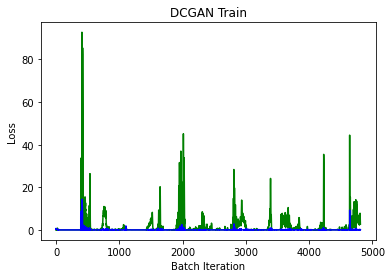

Epoch 75/100 :
     Batch 1/65 generator loss | discriminator loss : 2.820803165435791 | 0.07919543981552124 - batch took 4.458470582962036 s.
     Batch 2/65 generator loss | discriminator loss : 3.846142292022705 | 0.05897746980190277 - batch took 4.465242624282837 s.
     Batch 3/65 generator loss | discriminator loss : 5.121441841125488 | 0.01524252351373434 - batch took 4.359307765960693 s.
     Batch 4/65 generator loss | discriminator loss : 6.16084623336792 | 0.017379801720380783 - batch took 4.50022292137146 s.
     Batch 5/65 generator loss | discriminator loss : 6.290792465209961 | 0.002264775102958083 - batch took 4.43825888633728 s.
     Batch 6/65 generator loss | discriminator loss : 7.37047815322876 | 0.004267027135938406 - batch took 4.455250978469849 s.
     Batch 7/65 generator loss | discriminator loss : 6.975633144378662 | 0.054742224514484406 - batch took 4.337321519851685 s.
     Batch 8/65 generator loss | discriminator loss : 5.773518085479736 | 0.3379293978214

     Batch 64/65 generator loss | discriminator loss : 0.003475525416433811 | 0.0003007128252647817 - batch took 4.374300479888916 s.
     Batch 65/65 generator loss | discriminator loss : 0.0032661070581525564 | 0.003299285192042589 - batch took 1.229240894317627 s.


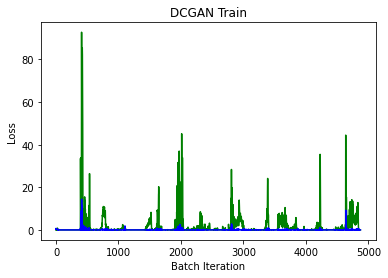

Epoch 76/100 :
     Batch 1/65 generator loss | discriminator loss : 0.0013400844763964415 | 0.0004458902985788882 - batch took 4.306345462799072 s.
     Batch 2/65 generator loss | discriminator loss : 0.010321592912077904 | 0.0001201943086925894 - batch took 4.456249237060547 s.
     Batch 3/65 generator loss | discriminator loss : 0.0018032763618975878 | 0.00011527398601174355 - batch took 4.420272588729858 s.
     Batch 4/65 generator loss | discriminator loss : 0.009863387793302536 | 0.0005948151811026037 - batch took 4.398285150527954 s.
     Batch 5/65 generator loss | discriminator loss : 0.02135840430855751 | 0.7545329332351685 - batch took 4.350313186645508 s.
     Batch 6/65 generator loss | discriminator loss : 0.025523310527205467 | 9.406282333657146e-05 - batch took 4.486230850219727 s.
     Batch 7/65 generator loss | discriminator loss : 0.012447735294699669 | 4.350922245066613e-05 - batch took 4.453250885009766 s.
     Batch 8/65 generator loss | discriminator loss : 0

     Batch 63/65 generator loss | discriminator loss : 0.0058075920678675175 | 0.01960899494588375 - batch took 4.398284912109375 s.
     Batch 64/65 generator loss | discriminator loss : 0.0015882585430517793 | 0.023566249758005142 - batch took 4.422269344329834 s.
     Batch 65/65 generator loss | discriminator loss : 0.5647528171539307 | 0.006317449267953634 - batch took 1.18326997756958 s.


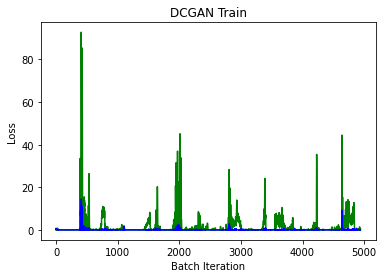

Epoch 77/100 :
     Batch 1/65 generator loss | discriminator loss : 0.1517287641763687 | 0.0016836810391396284 - batch took 4.42693305015564 s.
     Batch 2/65 generator loss | discriminator loss : 0.5836994051933289 | 0.0004471019492484629 - batch took 4.338320970535278 s.
     Batch 3/65 generator loss | discriminator loss : 1.093372106552124 | 4.289094795240089e-05 - batch took 4.4772374629974365 s.
     Batch 4/65 generator loss | discriminator loss : 0.4611128568649292 | 4.857269595959224e-05 - batch took 4.456249237060547 s.
     Batch 5/65 generator loss | discriminator loss : 0.8781546354293823 | 0.00010823986667674035 - batch took 5.169809341430664 s.
     Batch 6/65 generator loss | discriminator loss : 0.26278194785118103 | 0.00041338292066939175 - batch took 5.989301443099976 s.
     Batch 7/65 generator loss | discriminator loss : 0.5824300646781921 | 0.0012211805442348123 - batch took 5.046884298324585 s.
     Batch 8/65 generator loss | discriminator loss : 0.2888814806

     Batch 64/65 generator loss | discriminator loss : 3.618116534198634e-05 | 2.9159391488065012e-05 - batch took 4.721085071563721 s.
     Batch 65/65 generator loss | discriminator loss : 1.099656401493121e-05 | 9.159837645711377e-06 - batch took 1.2732138633728027 s.


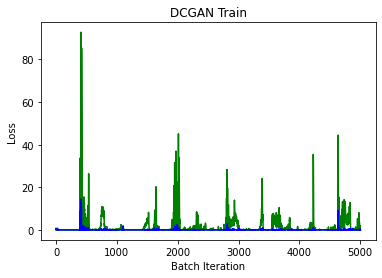

Epoch 78/100 :
     Batch 1/65 generator loss | discriminator loss : 6.084933374950197e-06 | 3.885149635607377e-05 - batch took 4.488230228424072 s.
     Batch 2/65 generator loss | discriminator loss : 1.4588514432034572e-06 | 3.174586527165957e-05 - batch took 4.38329291343689 s.
     Batch 3/65 generator loss | discriminator loss : 6.094269906498084e-07 | 2.447830956953112e-05 - batch took 4.472239255905151 s.
     Batch 4/65 generator loss | discriminator loss : 1.0893730859606876e-06 | 0.5726614594459534 - batch took 4.439259767532349 s.
     Batch 5/65 generator loss | discriminator loss : 8.332893344231707e-07 | 0.008175093680620193 - batch took 4.377297639846802 s.
     Batch 6/65 generator loss | discriminator loss : 1.5846376300032716e-06 | 0.0029661026783287525 - batch took 4.341320276260376 s.
     Batch 7/65 generator loss | discriminator loss : 2.407582769592409e-06 | 0.00012782480916939676 - batch took 4.514212608337402 s.
     Batch 8/65 generator loss | discriminator l

     Batch 63/65 generator loss | discriminator loss : 0.015680475160479546 | 0.001908699399791658 - batch took 5.303725004196167 s.
     Batch 64/65 generator loss | discriminator loss : 0.013023292645812035 | 0.002267713425680995 - batch took 6.1651928424835205 s.
     Batch 65/65 generator loss | discriminator loss : 0.028941862285137177 | 0.005926378071308136 - batch took 1.1962623596191406 s.


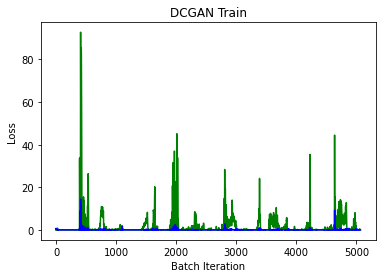

Epoch 79/100 :
     Batch 1/65 generator loss | discriminator loss : 0.0528094656765461 | 0.0034252216573804617 - batch took 4.717085123062134 s.
     Batch 2/65 generator loss | discriminator loss : 0.09927556663751602 | 0.016446121037006378 - batch took 5.118840456008911 s.
     Batch 3/65 generator loss | discriminator loss : 0.2293490469455719 | 0.0017968519823625684 - batch took 4.955940246582031 s.
     Batch 4/65 generator loss | discriminator loss : 0.29148563742637634 | 0.049431510269641876 - batch took 4.457248210906982 s.
     Batch 5/65 generator loss | discriminator loss : 0.14491215348243713 | 0.02195894718170166 - batch took 4.671116590499878 s.
     Batch 6/65 generator loss | discriminator loss : 0.048483915627002716 | 8.604304457549006e-05 - batch took 4.464245319366455 s.
     Batch 7/65 generator loss | discriminator loss : 0.016738971695303917 | 0.000846172624733299 - batch took 4.400282621383667 s.
     Batch 8/65 generator loss | discriminator loss : 0.0130673609

     Batch 64/65 generator loss | discriminator loss : 0.2147144228219986 | 0.22591137886047363 - batch took 4.4102783203125 s.
     Batch 65/65 generator loss | discriminator loss : 2.8816490173339844 | 0.0011417921632528305 - batch took 1.186267375946045 s.


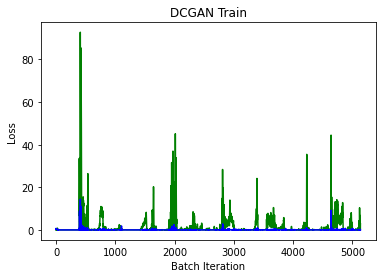

Epoch 80/100 :
     Batch 1/65 generator loss | discriminator loss : 7.628254413604736 | 7.2407019615639e-06 - batch took 4.434260129928589 s.
     Batch 2/65 generator loss | discriminator loss : 9.71263313293457 | 0.020072704181075096 - batch took 4.3443169593811035 s.
     Batch 3/65 generator loss | discriminator loss : 7.631913185119629 | 0.1712346076965332 - batch took 4.362308025360107 s.
     Batch 4/65 generator loss | discriminator loss : 3.123084306716919 | 0.07647112756967545 - batch took 4.538198471069336 s.
     Batch 5/65 generator loss | discriminator loss : 0.28523188829421997 | 0.08026524633169174 - batch took 4.54219651222229 s.
     Batch 6/65 generator loss | discriminator loss : 0.010665623471140862 | 0.00883827731013298 - batch took 4.704095840454102 s.
     Batch 7/65 generator loss | discriminator loss : 2.2599375247955322 | 0.4626578688621521 - batch took 4.660123825073242 s.
     Batch 8/65 generator loss | discriminator loss : 7.7885236740112305 | 0.03821905

     Batch 65/65 generator loss | discriminator loss : 5.213988304138184 | 0.032739657908678055 - batch took 1.1822702884674072 s.


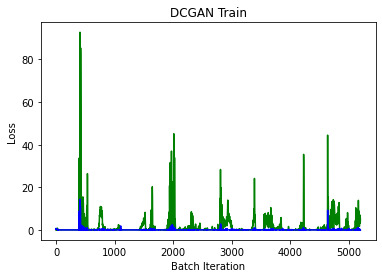

Epoch 81/100 :
     Batch 1/65 generator loss | discriminator loss : 5.765035629272461 | 0.0730045735836029 - batch took 4.479234457015991 s.
     Batch 2/65 generator loss | discriminator loss : 5.9919328689575195 | 0.0082831010222435 - batch took 4.3842933177948 s.
     Batch 3/65 generator loss | discriminator loss : 6.693426132202148 | 0.003803017782047391 - batch took 4.517210245132446 s.
     Batch 4/65 generator loss | discriminator loss : 7.086112022399902 | 0.0023635956458747387 - batch took 4.73907470703125 s.
     Batch 5/65 generator loss | discriminator loss : 7.461056709289551 | 0.003575083101168275 - batch took 4.539197683334351 s.
     Batch 6/65 generator loss | discriminator loss : 7.621976852416992 | 0.053263936191797256 - batch took 4.487231254577637 s.
     Batch 7/65 generator loss | discriminator loss : 7.412040710449219 | 0.022298647090792656 - batch took 4.823022842407227 s.
     Batch 8/65 generator loss | discriminator loss : 6.76433801651001 | 0.192143559455

     Batch 65/65 generator loss | discriminator loss : 3.546475410461426 | 0.009057397954165936 - batch took 1.2242441177368164 s.


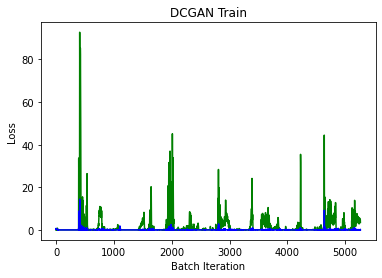

Epoch 82/100 :
     Batch 1/65 generator loss | discriminator loss : 4.111507892608643 | 0.015739277005195618 - batch took 4.345614910125732 s.
     Batch 2/65 generator loss | discriminator loss : 4.535285949707031 | 0.027584638446569443 - batch took 4.308339595794678 s.
     Batch 3/65 generator loss | discriminator loss : 4.697656631469727 | 0.11510735750198364 - batch took 4.442258358001709 s.
     Batch 4/65 generator loss | discriminator loss : 5.126410484313965 | 0.012954585254192352 - batch took 4.355310916900635 s.
     Batch 5/65 generator loss | discriminator loss : 5.565310478210449 | 0.03469588980078697 - batch took 4.353312730789185 s.
     Batch 6/65 generator loss | discriminator loss : 5.392455101013184 | 0.14720432460308075 - batch took 4.355311632156372 s.
     Batch 7/65 generator loss | discriminator loss : 5.646394729614258 | 0.005996766500174999 - batch took 4.448253631591797 s.
     Batch 8/65 generator loss | discriminator loss : 5.6826653480529785 | 0.00293831

     Batch 65/65 generator loss | discriminator loss : 4.533107757568359 | 0.031892385333776474 - batch took 1.1922645568847656 s.


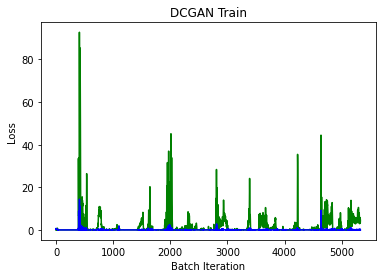

Epoch 83/100 :
     Batch 1/65 generator loss | discriminator loss : 5.661629676818848 | 0.007190173491835594 - batch took 4.446749687194824 s.
     Batch 2/65 generator loss | discriminator loss : 6.419120788574219 | 0.01490885391831398 - batch took 4.488229513168335 s.
     Batch 3/65 generator loss | discriminator loss : 6.617570877075195 | 0.09535498917102814 - batch took 4.3792970180511475 s.
     Batch 4/65 generator loss | discriminator loss : 5.938444137573242 | 0.15741783380508423 - batch took 4.335323095321655 s.
     Batch 5/65 generator loss | discriminator loss : 5.476822853088379 | 0.0024297041818499565 - batch took 4.3882904052734375 s.
     Batch 6/65 generator loss | discriminator loss : 5.5891618728637695 | 0.02518644742667675 - batch took 4.360308647155762 s.
     Batch 7/65 generator loss | discriminator loss : 4.568680763244629 | 0.009028435684740543 - batch took 4.368303298950195 s.
     Batch 8/65 generator loss | discriminator loss : 4.880493640899658 | 0.010377

     Batch 65/65 generator loss | discriminator loss : 6.640541076660156 | 0.14123211801052094 - batch took 1.2882051467895508 s.


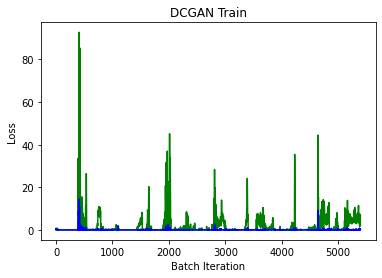

Epoch 84/100 :
     Batch 1/65 generator loss | discriminator loss : 7.56709098815918 | 0.0172364991158247 - batch took 4.656124830245972 s.
     Batch 2/65 generator loss | discriminator loss : 10.209238052368164 | 0.026946816593408585 - batch took 4.417272567749023 s.
     Batch 3/65 generator loss | discriminator loss : 11.976430892944336 | 0.036976415663957596 - batch took 4.426267623901367 s.
     Batch 4/65 generator loss | discriminator loss : 11.469551086425781 | 0.04261750355362892 - batch took 4.414275407791138 s.


KeyboardInterrupt: 

In [24]:
train_dcgan(epochs=100)